<a href="https://colab.research.google.com/github/yingzibu/drug_design_JAK/blob/main/drugVAE/chemVAE%2BKL_annealing_08_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -R 'molecular-vae'
!git clone https://github.com/aksub99/molecular-vae.git
import zipfile
zip_ref = zipfile.ZipFile('molecular-vae/data/processed.zip', 'r')
zip_ref.extractall('molecular-vae/data/')
zip_ref.close()

rm: cannot remove 'molecular-vae': No such file or directory
Cloning into 'molecular-vae'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 185
Receiving objects: 100% (188/188), 2.99 MiB | 28.32 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import gzip
import pandas
import h5py
import numpy as np
from __future__ import print_function
import argparse
import os
import h5py
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn import model_selection
from tqdm import tqdm

In [ ]:
h5f = h5py.File('/content/molecular-vae/data/processed.h5', 'r')
data = h5f['data_test'][:] # (10000, 120, 33)

In [ ]:
charset = h5f['charset'][:]
charset

array([b' ', b'#', b')', b'(', b'+', b'-', b'/', b'1', b'3', b'2', b'5',
       b'4', b'7', b'6', b'=', b'@', b'C', b'B', b'F', b'I', b'H', b'O',
       b'N', b'S', b'[', b']', b'\\', b'c', b'l', b'o', b'n', b's', b'r'],
      dtype='|S1')

In [ ]:
def load_dataset(filename, split = True):
    h5f = h5py.File(filename, 'r')
    if split:
        data_train = h5f['data_train'][:]
    else:
        data_train = None
    data_test = h5f['data_test'][:]
    charset =  h5f['charset'][:]
    h5f.close()
    if split:
        return (data_train, data_test, charset)
    else:
        return (data_test, charset)

In [ ]:
from torch.autograd import Variable
max_len = 120 # max_len of molecule
alphabet_len = len(charset)

class MolecularVAE(nn.Module):
    def __init__(self, in_dim=[250, max_len, alphabet_len], z_dim=292):
        """
        param: in_dim = [batch_size, max_len, len(alphabet)]
        param: z_dim: z dimension
        """

        super(MolecularVAE, self).__init__()

        (_, max_len, alphabet_len) = in_dim
        self.max_len = max_len
        self.alphabet_len = alphabet_len
        self.kld = 0

        self.conv_1 = nn.Conv1d(max_len, 9, kernel_size = 9) #[bs, 9, 25]
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9) # [bs, 9, 17]
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11) # [bs, 10, 7]
        self.linear_0 = nn.Linear(70, 435)
        self.mu = nn.Linear(435, z_dim)
        self.logvar = nn.Linear(435, z_dim)

        self.linear_3 = nn.Linear(z_dim, z_dim)
        self.gru = nn.GRU(z_dim, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, alphabet_len)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()


    def encode(self, x):

        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1) # (batch_size, size(-2) * size(-1))
        # print('after view', x.shape)
        x = F.selu(self.linear_0(x))

        mu = self.mu(x)
        logvar = F.softplus(self.logvar(x))
        return mu, logvar

    def reparametrize(self, mu, logvar):
        epsilon = Variable(torch.rand(mu.size()), requires_grad=False)
        if mu.is_cuda: epsilon = epsilon.cuda()
        std = logvar.mul(0.5).exp_()
        z = mu.addcmul(std, epsilon)
        return z

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, self.max_len, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def update_kld(self, mu, logvar):
        self.kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    def get_kld(self):
        return self.kld

    def forward(self, x):
        mu, logvar = self.encode(x)
        self.update_kld(mu, logvar)
        z = self.reparametrize(mu, logvar)
        return self.decode(z)

# from torchsummary import summary

# summary(MolecularVAE(), (250,120, 33))
MolecularVAE()

MolecularVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (linear_0): Linear(in_features=70, out_features=435, bias=True)
  (mu): Linear(in_features=435, out_features=292, bias=True)
  (logvar): Linear(in_features=435, out_features=292, bias=True)
  (linear_3): Linear(in_features=292, out_features=292, bias=True)
  (gru): GRU(292, 501, num_layers=3, batch_first=True)
  (linear_4): Linear(in_features=501, out_features=33, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [ ]:
# n = nn.Conv1d(max_len, 9, kernel_size = 9)
# a = torch.randn(250, max_len, alphabet_len)
# out = n(a)
# print(out.size())
# n1 = nn.Conv1d(9, 9, kernel_size=9)
# out = n1(out)
# print(out.size())
# n2 = nn.Conv1d(9, 10, kernel_size=11)
# out = n2(out)
# print(out.size())
import numpy as np
import math
import matplotlib.pyplot as plt
import os
def frange_cycle_linear(start, stop, n_epoch, n_cycle=4, ratio=0.5):
    L = np.ones(n_epoch)
    period = n_epoch/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):

        v , i = start , 0
        while v <= stop and (int(i+c*period) < n_epoch):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L


In [ ]:
data_train, data_test, charset = load_dataset('molecular-vae/data/processed.h5')
data_train = torch.utils.data.TensorDataset(torch.from_numpy(data_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=250, shuffle=True)

torch.manual_seed(42)
data_test = torch.utils.data.TensorDataset(torch.from_numpy(data_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=250, shuffle=True)


cuda = torch.cuda.is_available()

device = 'cuda' if cuda else 'cpu'



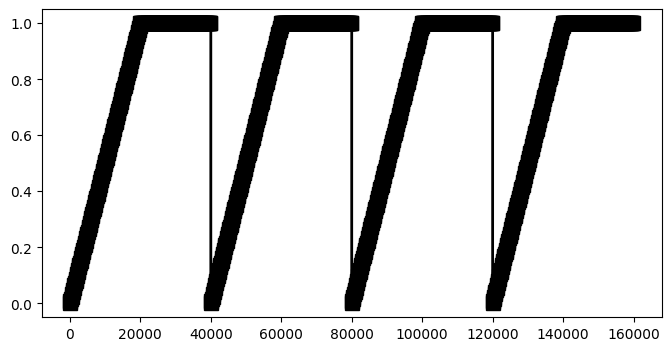

In [ ]:
batch_size = 250
epochs= 1000
n_epoch = int(len(train_loader)*epochs)

beta_np_cyc = frange_cycle_linear(0.0, 1.0, n_epoch, 4)

fig=plt.figure(figsize=(8,4.0))
stride = max(int(n_epoch / epochs), 1)

plt.plot(range(n_epoch), beta_np_cyc, '-',
         label='Cyclical', marker= 's', color='k',
         markevery=stride,lw=2,  mec='k', mew=1 , markersize=10)

In [ ]:
len(train_loader), len(train_loader.dataset)

(160, 40000)

In [ ]:
model = MolecularVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))

def train(epoch, beta_kl=beta_np_cyc):
    model.train()
    train_loss = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader),
                        desc=f'epoch {epoch}'):
        data = data[0].to(device)
        optimizer.zero_grad()
        output = model(data)

        BCE = F.binary_cross_entropy(output, data, reduction='sum')
        KLD = model.get_kld()
        beta = beta_kl[i*epoch]
        loss = BCE + beta * KLD
        loss.backward()
        train_loss += loss.data.item()
        optimizer.step()


    train_loss = train_loss/len(train_loader.dataset)
    print(f'train \t loss: {train_loss:.3f} step: {i*epoch} KLDbeta: {beta:.3f}')
    return train_loss

def test(epoch):
    model.eval()
    test_loss = 0
    for data in test_loader:
        data = data[0].to(device)
        output = model(data)
        BCE = F.binary_cross_entropy(output, data,
                                      reduction='sum').data.item()
        KLD = model.get_kld().data.item()

        test_loss += BCE + KLD

    len_test = len(test_loader.dataset)
    test_loss, BCE, KLD = test_loss/len_test, BCE/len_test, KLD/len_test

    print(f'test \t loss: {test_loss:.3f}; BCE: {BCE:.3f}; KLD: {KLD:.3f}')
    return test_loss



In [ ]:
# len(test_loader.dataset)

10000

In [ ]:
# loss_dict = {}
# loss_dict[1] = [12, 2]
# loss_dict[2] = [3, 1]

# fig = plt.figure()
# train_losses = np.array(list(loss_dict.values()))[:, 0]
# test_losses = np.array(list(loss_dict.values()))[:, 1]
# plt.plot(list(loss_dict.keys()), train_losses, label='train')
# plt.plot(list(loss_dict.keys()), test_losses , label='test')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.title('loss during training')
# plt.legend()
# plt.show()

def get_min(d:dict):

    min_key = next(iter(d))

    # Iterate over the keys in the dictionary
    for key in d:
        # If the value of the current key is greater than the value of max_key, update max_key
        if d[key] < d[min_key]:
            min_key = key
    return min_key, d[min_key]

def plot_loss(train_dict, test_dict):
    fig = plt.figure()
    plt.plot(list(train_dict.keys()), list(train_dict.values()), label='train')
    plt.plot(list(test_dict.keys()), list(test_dict.values()), label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('loss during training')
    plt.legend()
    plt.show()

filepath = '/content/drive/MyDrive/A_MODEL/chemVAE/'

def save_pkl(a:dict, filename=filepath+'filename.pickle'):
    import pickle
    with open(filename, 'wb') as handle:
        pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # with open('filename.pickle', 'rb') as handle:
    #     b = pickle.load(handle)

    # print(a == b)

epoch 0: 100%|██████████| 160/160 [00:45<00:00,  3.55it/s]


train 	 loss: 142.096  KLD beta: 0.000
test 	 loss: 342.075


epoch 1: 100%|██████████| 160/160 [00:47<00:00,  3.37it/s]


train 	 loss: 120.804  KLD beta: 0.008
test 	 loss: 199.726


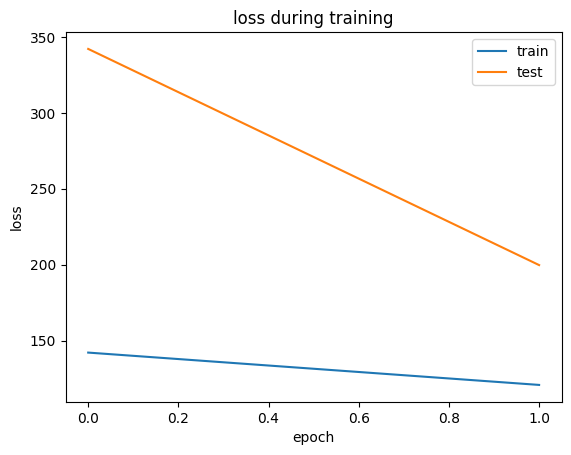

epoch 2: 100%|██████████| 160/160 [00:50<00:00,  3.16it/s]


train 	 loss: 116.219  KLD beta: 0.016
test 	 loss: 161.984


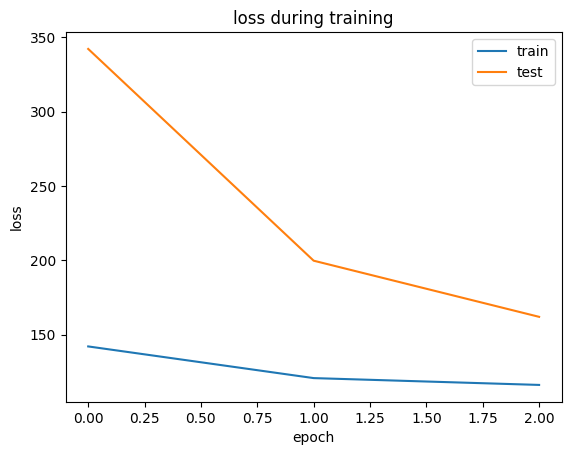

epoch 3: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 112.249  KLD beta: 0.024
test 	 loss: 148.809


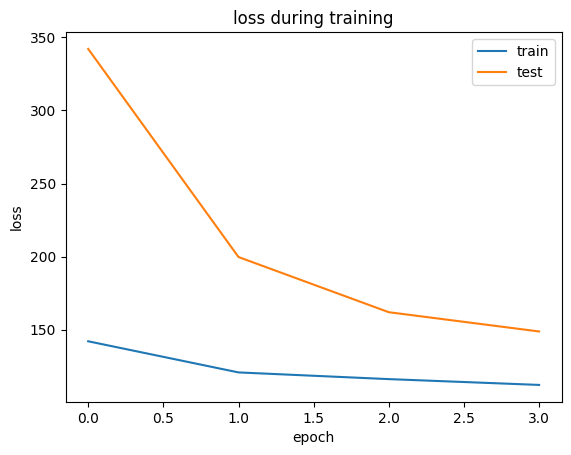

epoch 4: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 111.185  KLD beta: 0.032
test 	 loss: 141.015


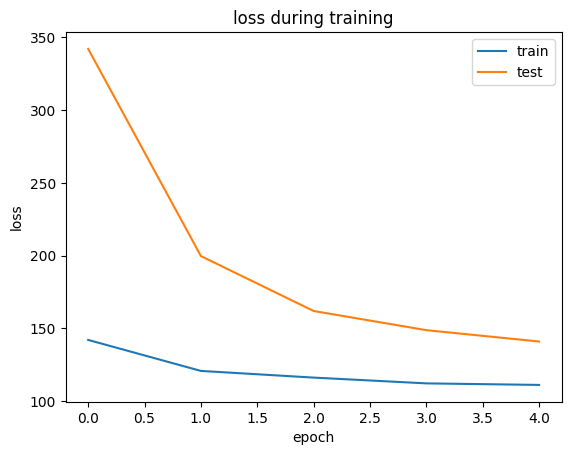

epoch 5: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 109.537  KLD beta: 0.040
test 	 loss: 136.841


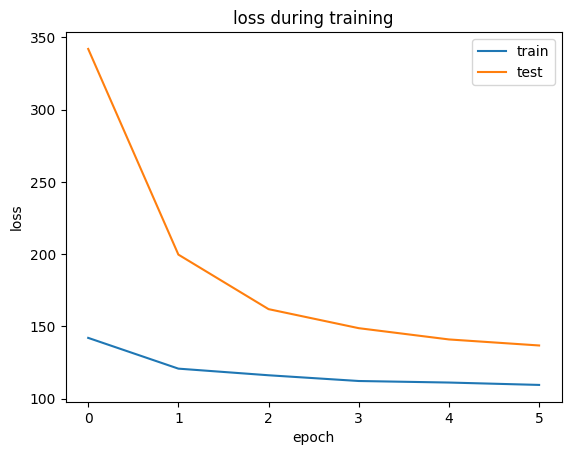

epoch 6: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 111.195  KLD beta: 0.048
test 	 loss: 135.496


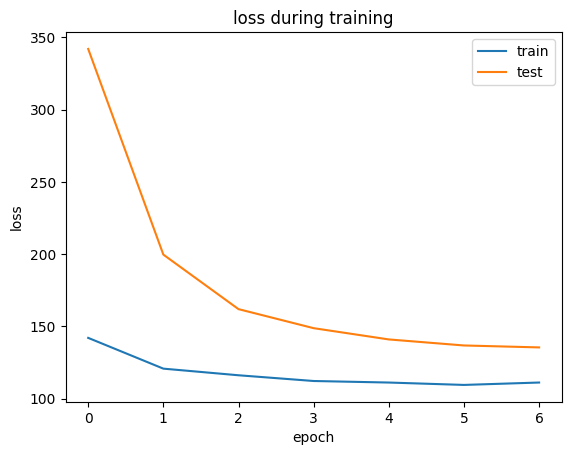

epoch 7: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 108.237  KLD beta: 0.056
test 	 loss: 152.685


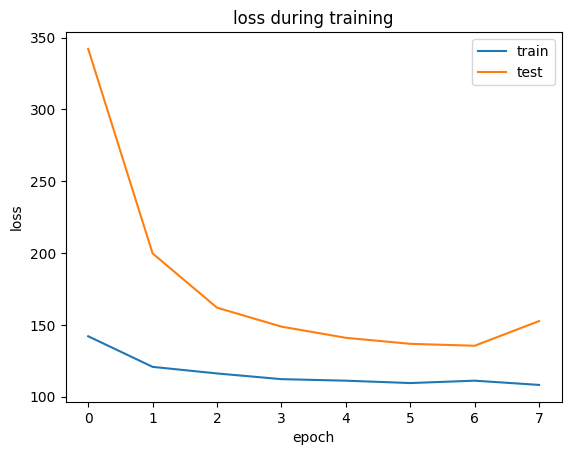

epoch 8: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 108.002  KLD beta: 0.064
test 	 loss: 126.357


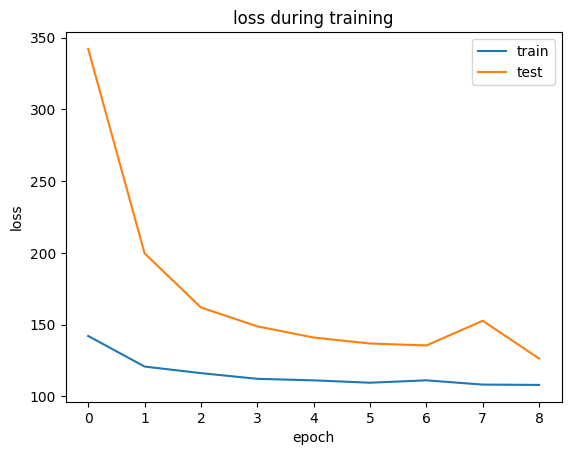

epoch 9: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 107.388  KLD beta: 0.072
test 	 loss: 124.473


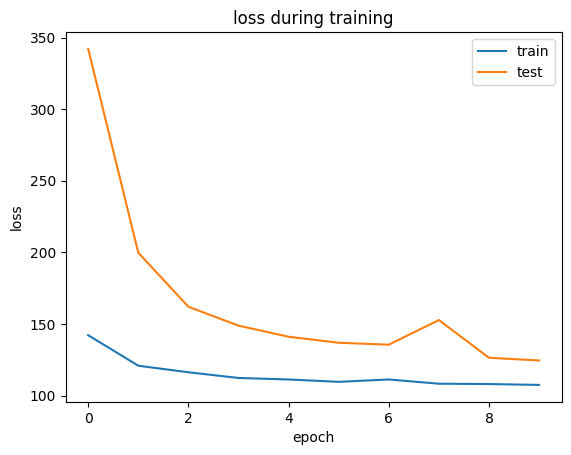

epoch 10: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 107.373  KLD beta: 0.079
test 	 loss: 130.065


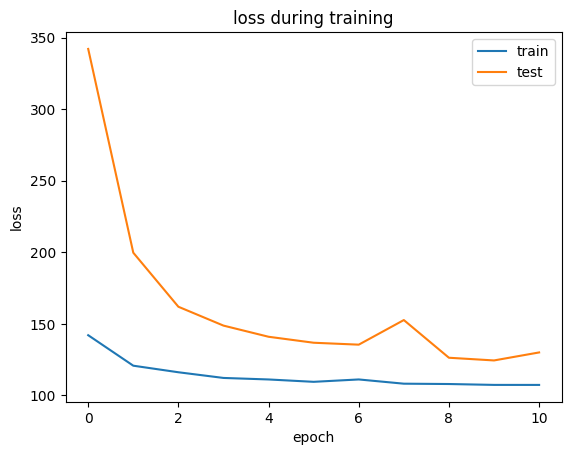

epoch 11: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 106.100  KLD beta: 0.087
test 	 loss: 124.119


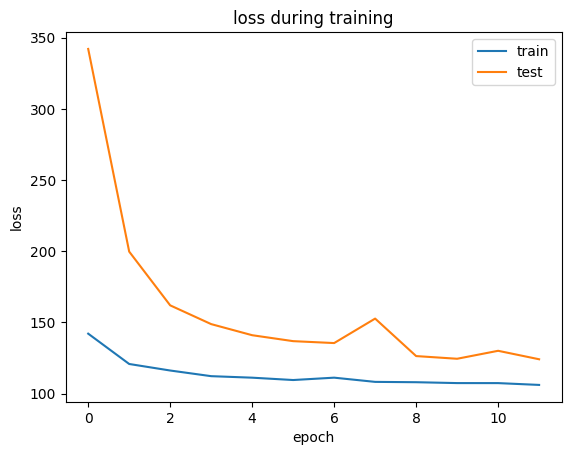

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_11.pt


epoch 12: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 106.545  KLD beta: 0.095
test 	 loss: 125.078


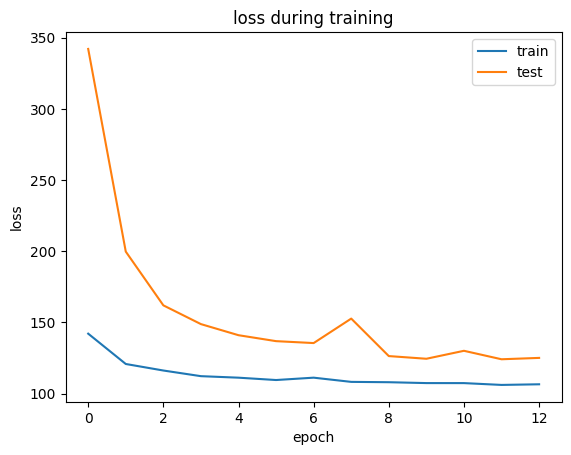

epoch 13: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 106.441  KLD beta: 0.103
test 	 loss: 123.491


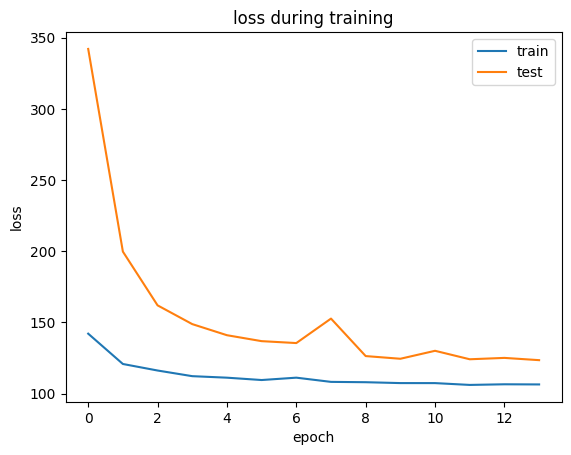

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_13.pt


epoch 14: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 103.958  KLD beta: 0.111
test 	 loss: 118.792


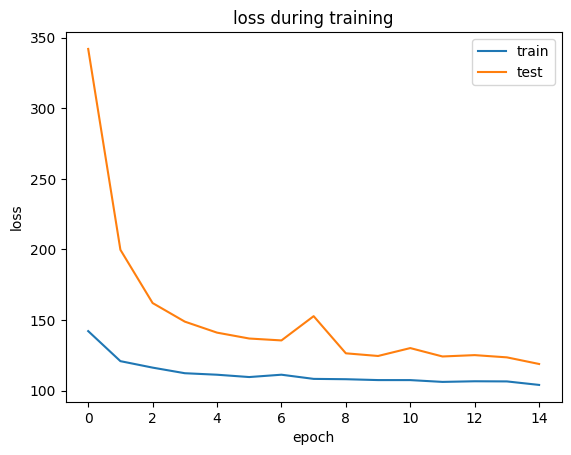

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_14.pt


epoch 15: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 100.003  KLD beta: 0.119
test 	 loss: 115.197


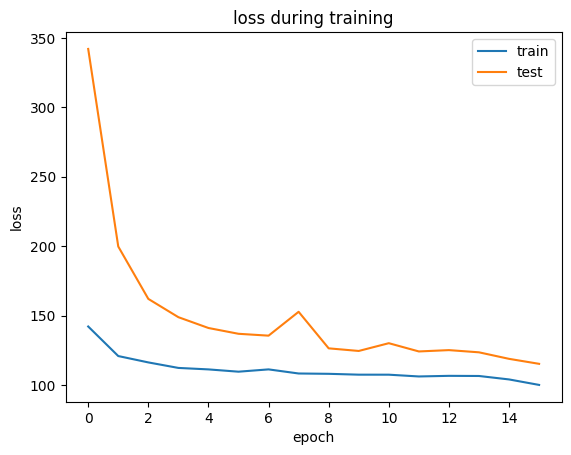

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_15.pt


epoch 16: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 98.616  KLD beta: 0.127
test 	 loss: 113.759


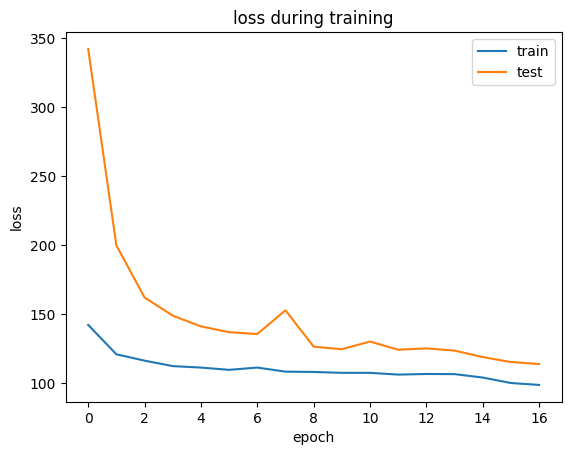

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_16.pt


epoch 17: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 97.140  KLD beta: 0.135
test 	 loss: 113.636


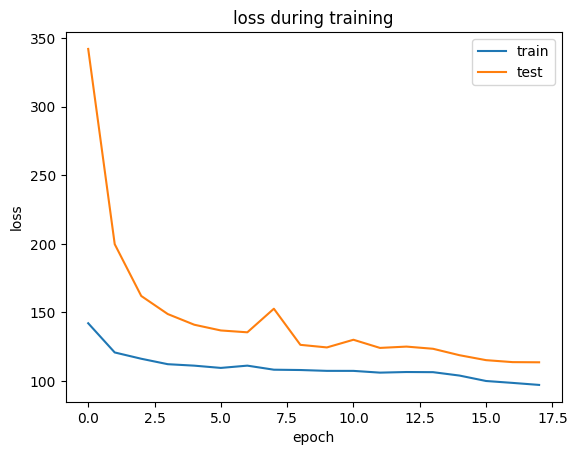

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_17.pt


epoch 18: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 96.201  KLD beta: 0.143
test 	 loss: 113.270


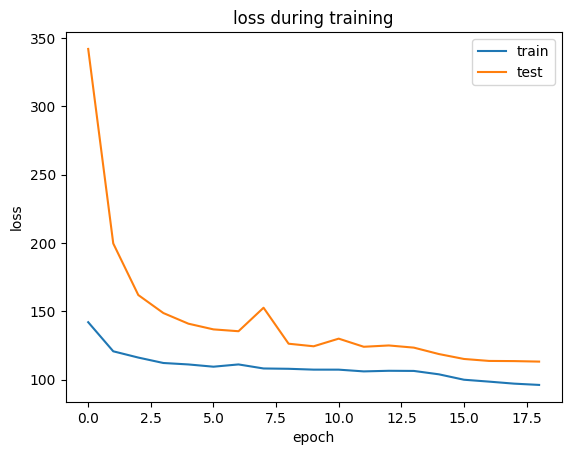

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_18.pt


epoch 19: 100%|██████████| 160/160 [00:50<00:00,  3.18it/s]


train 	 loss: 95.079  KLD beta: 0.151
test 	 loss: 113.369


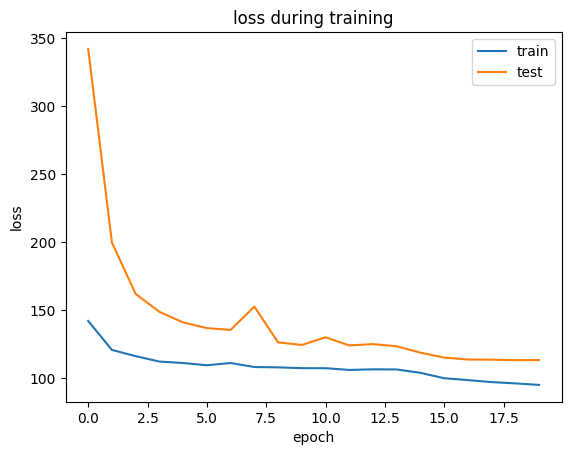

epoch 20: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 94.755  KLD beta: 0.159
test 	 loss: 111.455


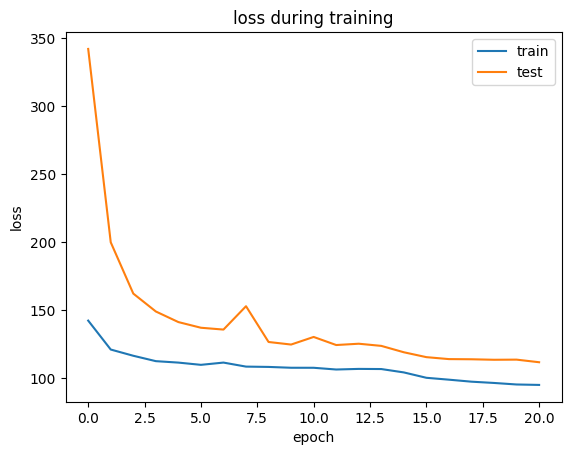

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_20.pt


epoch 21: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 93.613  KLD beta: 0.167
test 	 loss: 116.578


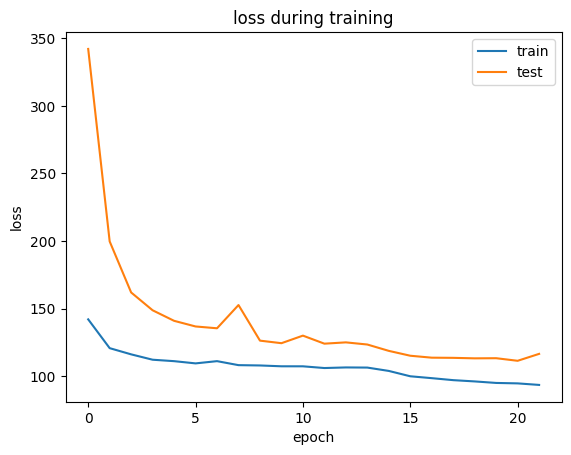

epoch 22: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 93.240  KLD beta: 0.175
test 	 loss: 109.818


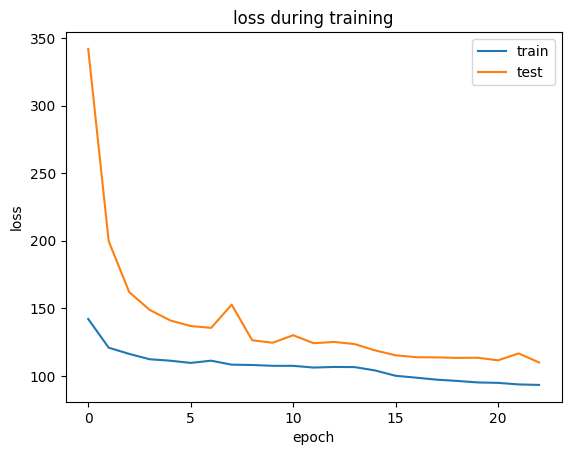

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_22.pt


epoch 23: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 93.308  KLD beta: 0.183
test 	 loss: 110.370


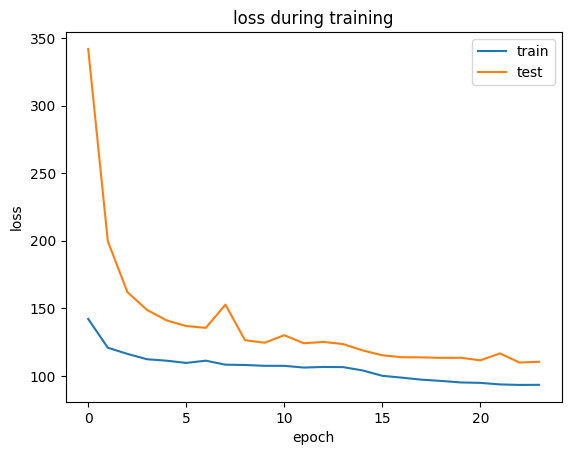

epoch 24: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 91.160  KLD beta: 0.191
test 	 loss: 108.197


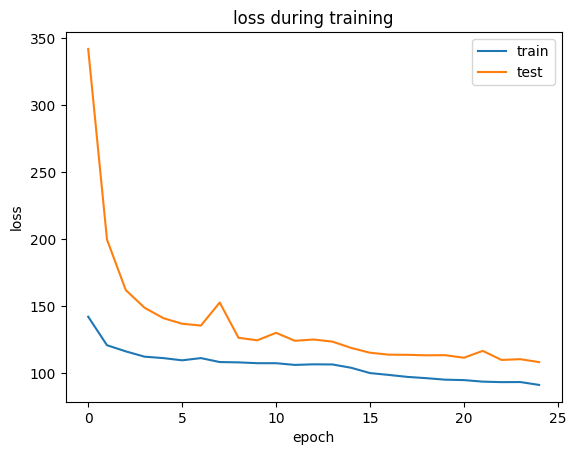

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_24.pt


epoch 25: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 90.962  KLD beta: 0.199
test 	 loss: 108.200


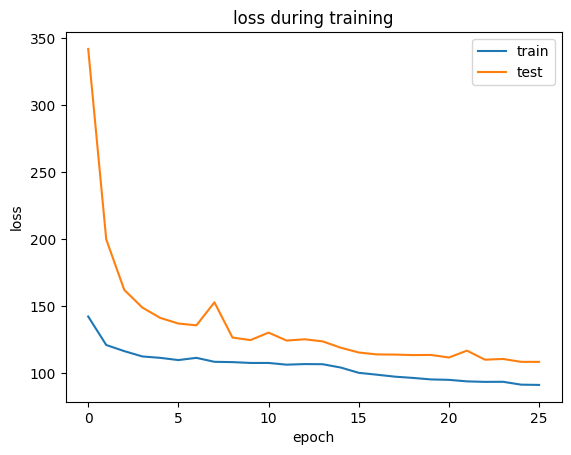

epoch 26: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 90.599  KLD beta: 0.207
test 	 loss: 106.844


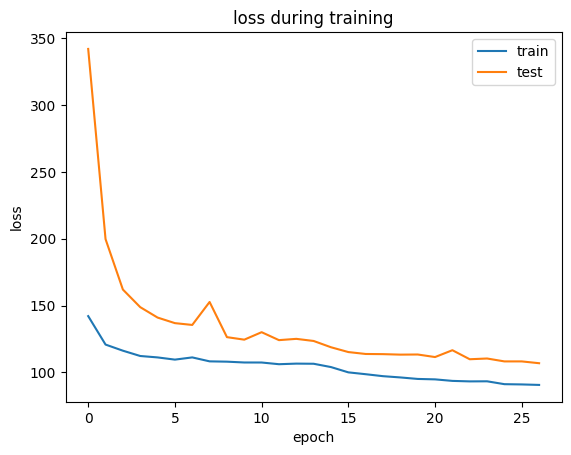

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_26.pt


epoch 27: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 90.076  KLD beta: 0.215
test 	 loss: 106.947


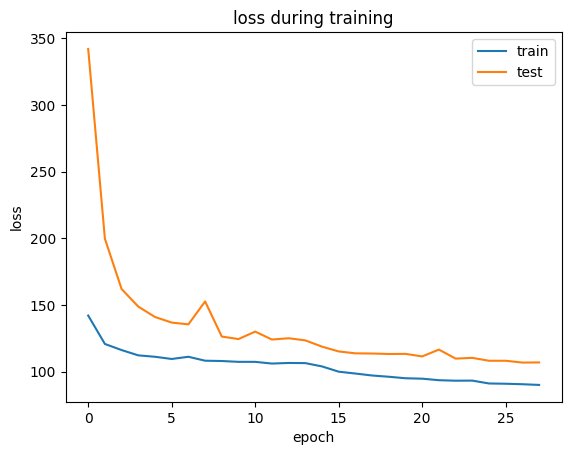

epoch 28: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 89.592  KLD beta: 0.223
test 	 loss: 106.379


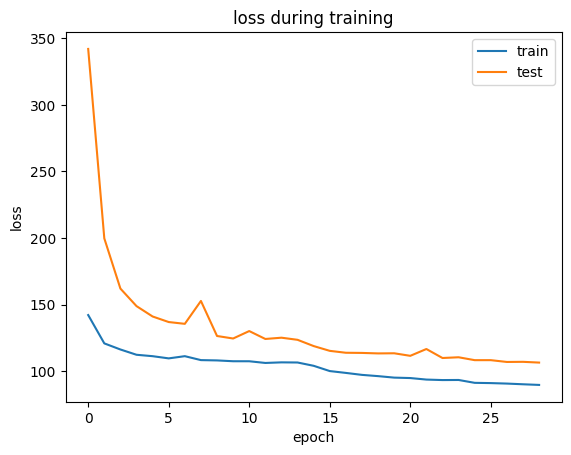

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_28.pt


epoch 29: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 89.232  KLD beta: 0.231
test 	 loss: 105.572


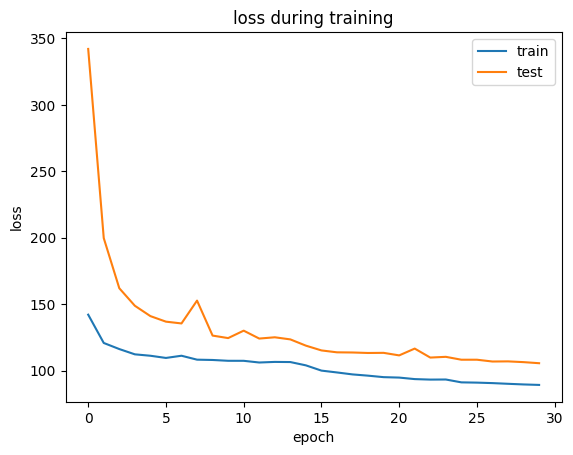

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_29.pt


epoch 30: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 88.339  KLD beta: 0.238
test 	 loss: 104.660


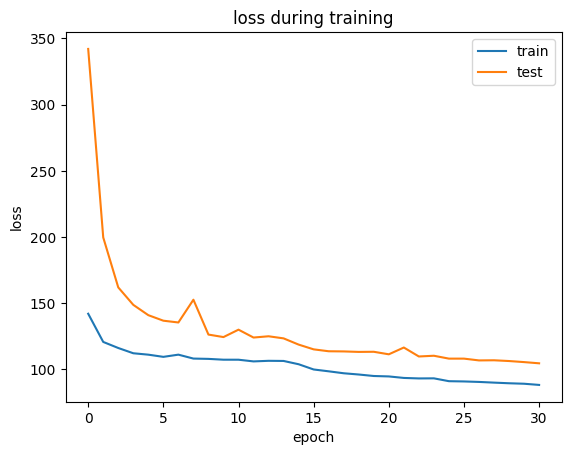

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_30.pt


epoch 31: 100%|██████████| 160/160 [00:50<00:00,  3.19it/s]


train 	 loss: 87.791  KLD beta: 0.246
test 	 loss: 103.933


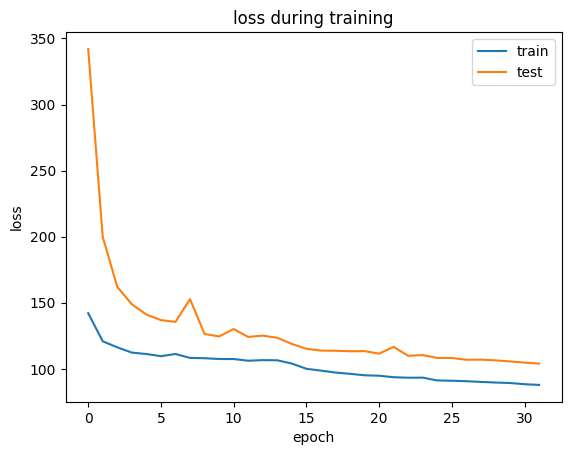

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_31.pt


epoch 32: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 87.516  KLD beta: 0.254
test 	 loss: 103.734


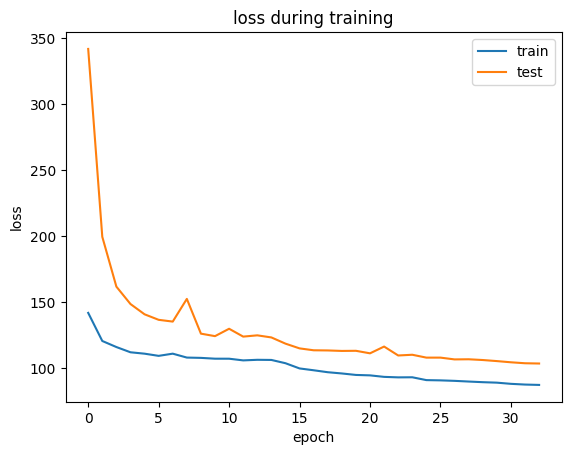

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_32.pt


epoch 33: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 87.273  KLD beta: 0.262
test 	 loss: 104.809


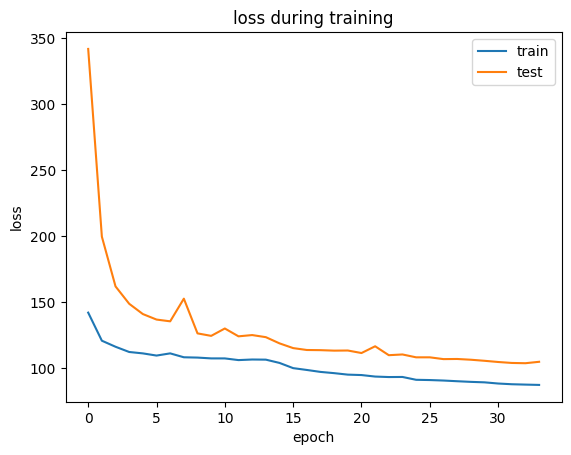

epoch 34: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 86.730  KLD beta: 0.270
test 	 loss: 103.398


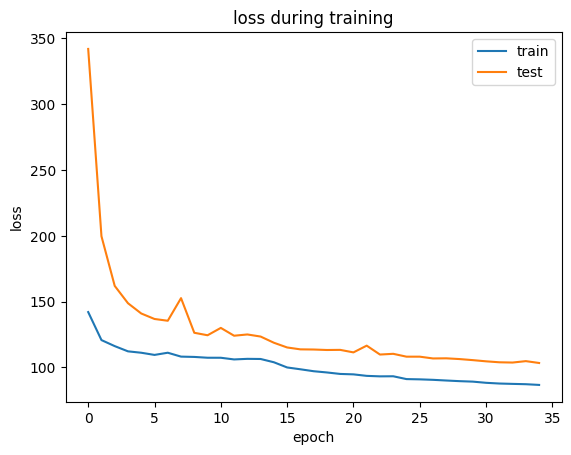

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_34.pt


epoch 35: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 86.562  KLD beta: 0.278
test 	 loss: 101.855


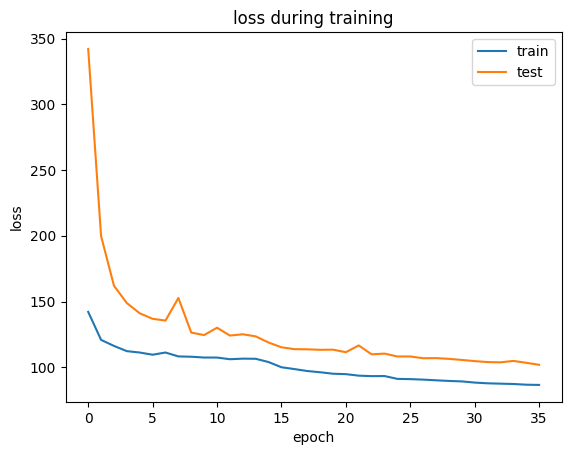

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_35.pt


epoch 36: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 85.945  KLD beta: 0.286
test 	 loss: 101.816


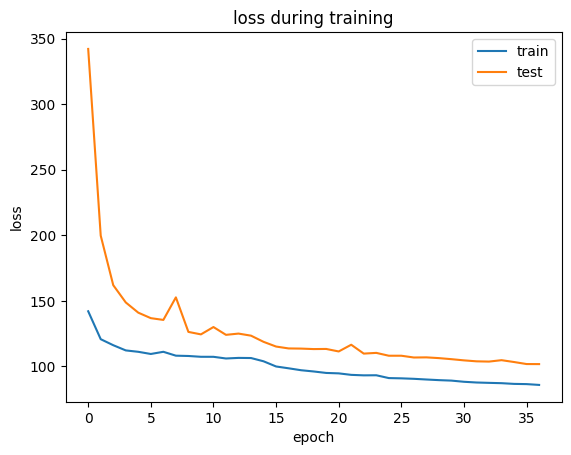

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_36.pt


epoch 37: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 85.389  KLD beta: 0.294
test 	 loss: 99.601


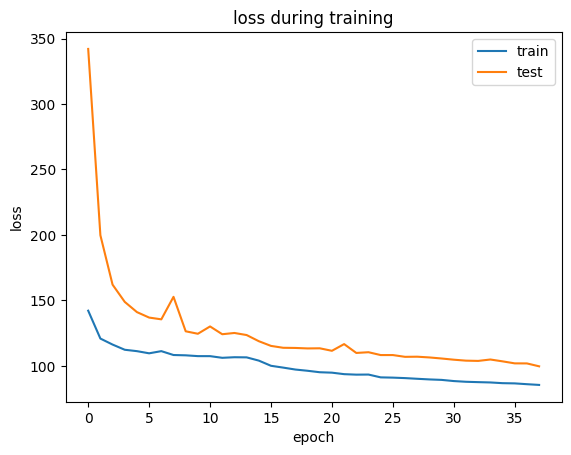

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_37.pt


epoch 38: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 84.306  KLD beta: 0.302
test 	 loss: 99.368


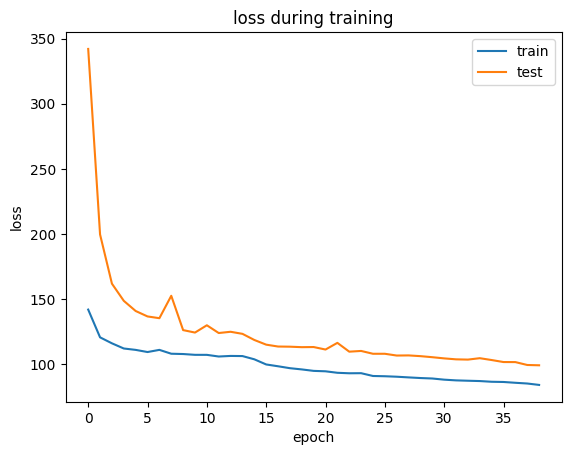

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_38.pt


epoch 39: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 84.453  KLD beta: 0.310
test 	 loss: 103.075


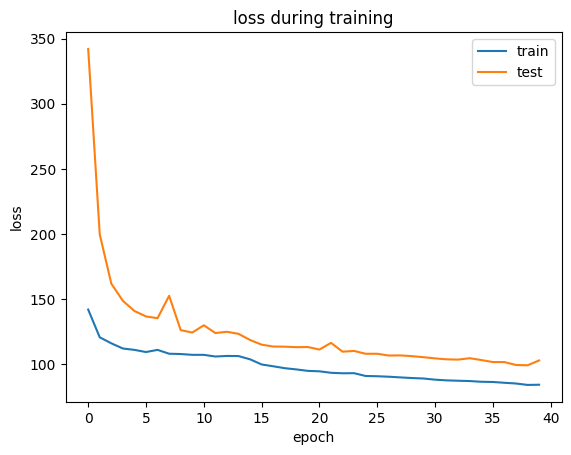

epoch 40: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 82.881  KLD beta: 0.318
test 	 loss: 99.389


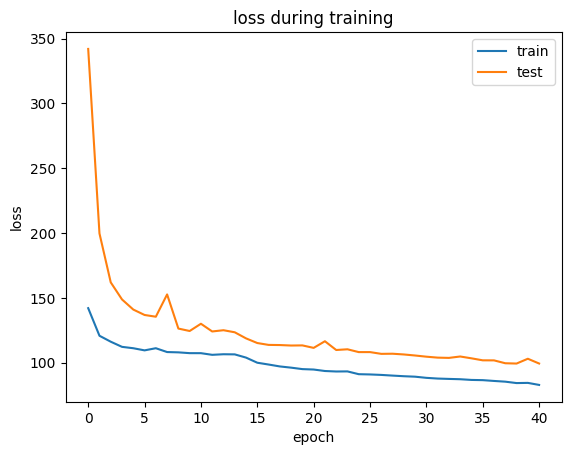

epoch 41: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 82.763  KLD beta: 0.326
test 	 loss: 96.526


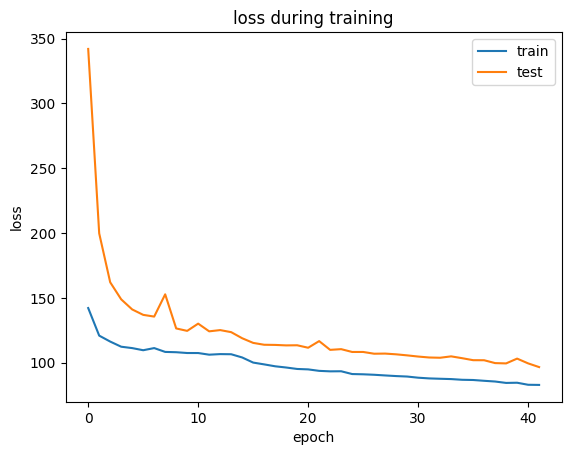

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_41.pt


epoch 42: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 82.181  KLD beta: 0.334
test 	 loss: 97.190


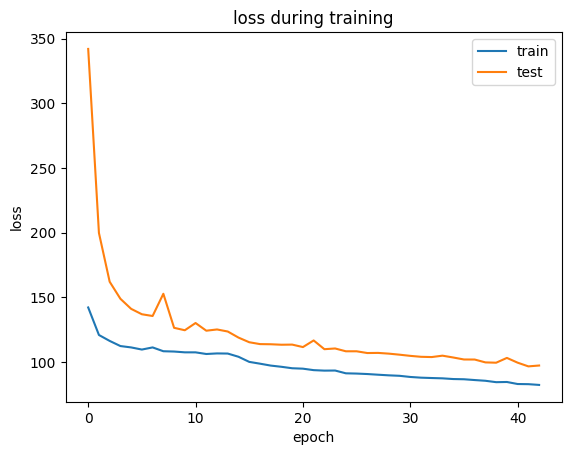

epoch 43: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 81.779  KLD beta: 0.342
test 	 loss: 96.699


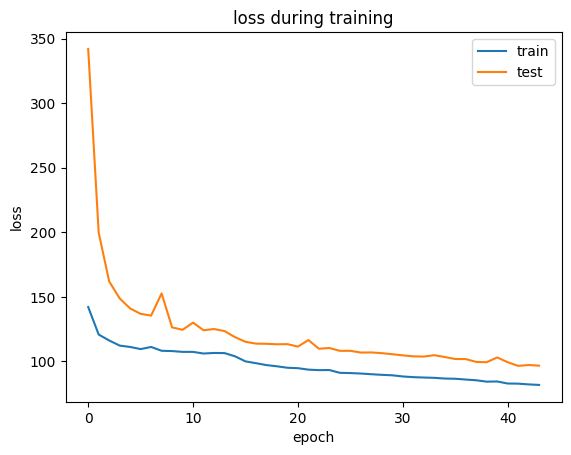

epoch 44: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 80.768  KLD beta: 0.350
test 	 loss: 94.901


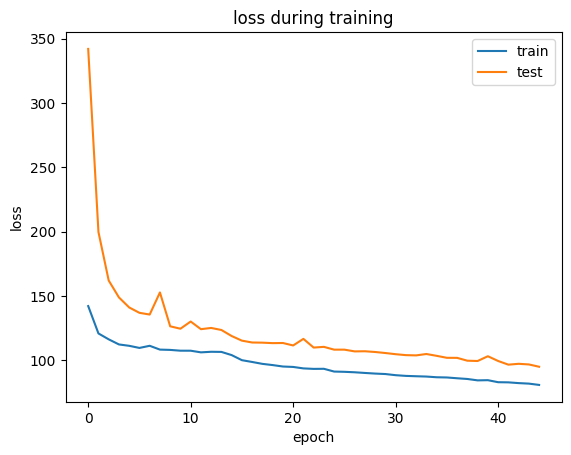

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_44.pt


epoch 45: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 80.053  KLD beta: 0.358
test 	 loss: 95.801


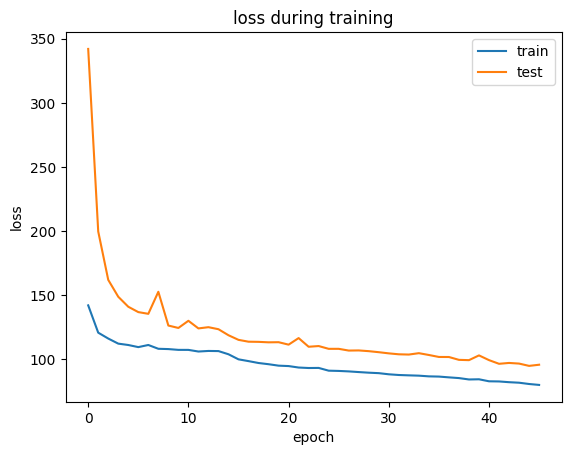

epoch 46: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 79.675  KLD beta: 0.366
test 	 loss: 94.777


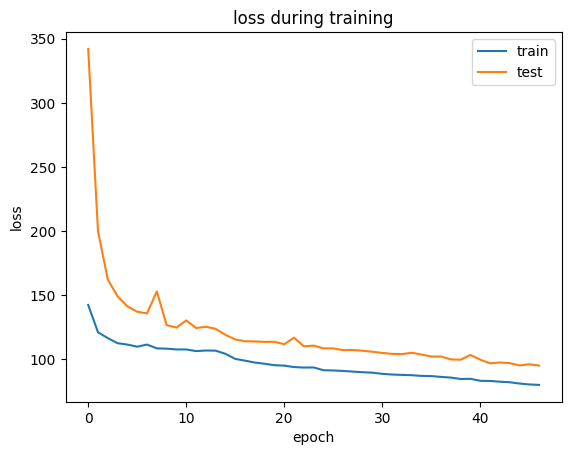

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_46.pt


epoch 47: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 79.715  KLD beta: 0.374
test 	 loss: 92.710


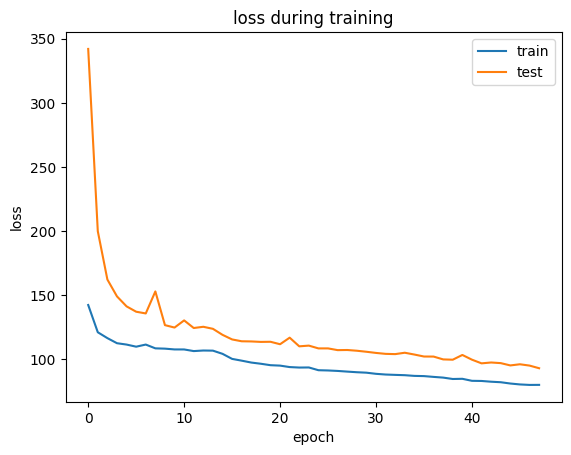

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_47.pt


epoch 48: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 78.383  KLD beta: 0.382
test 	 loss: 92.274


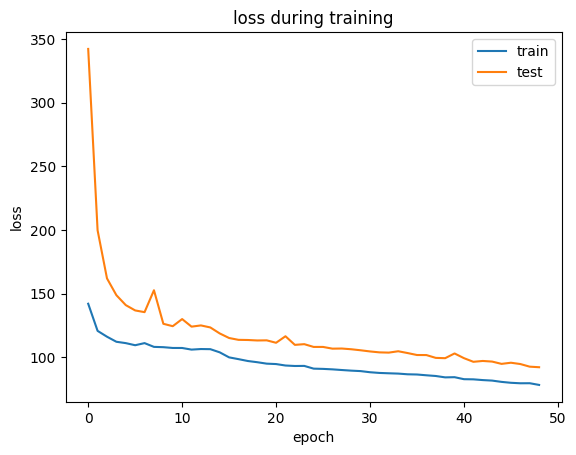

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_48.pt


epoch 49: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 78.300  KLD beta: 0.390
test 	 loss: 92.178


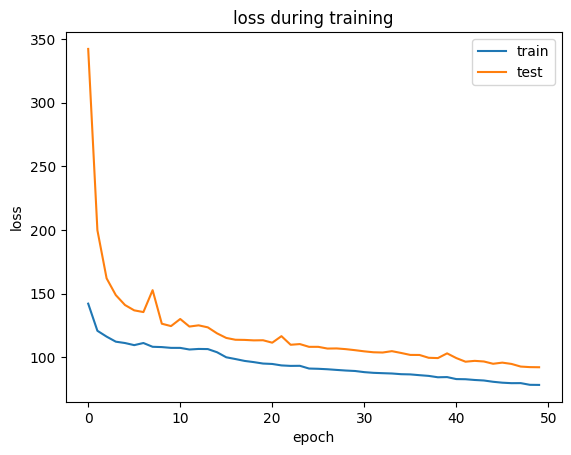

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_49.pt


epoch 50: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 77.532  KLD beta: 0.397
test 	 loss: 91.376


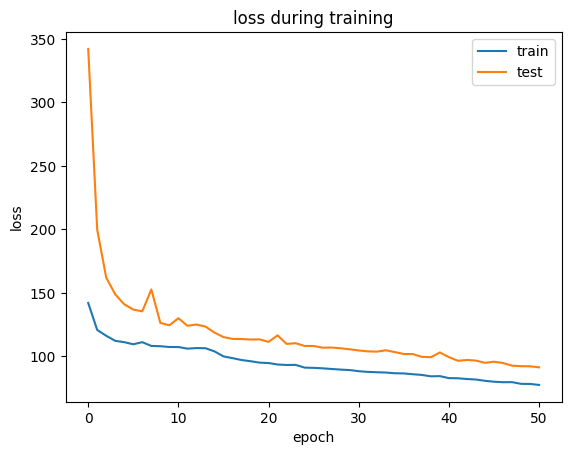

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_50.pt


epoch 51: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 77.257  KLD beta: 0.405
test 	 loss: 90.734


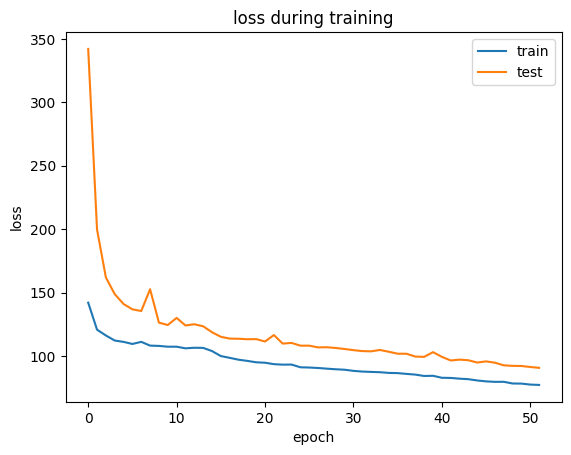

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_51.pt


epoch 52: 100%|██████████| 160/160 [00:49<00:00,  3.21it/s]


train 	 loss: 76.870  KLD beta: 0.413
test 	 loss: 95.902


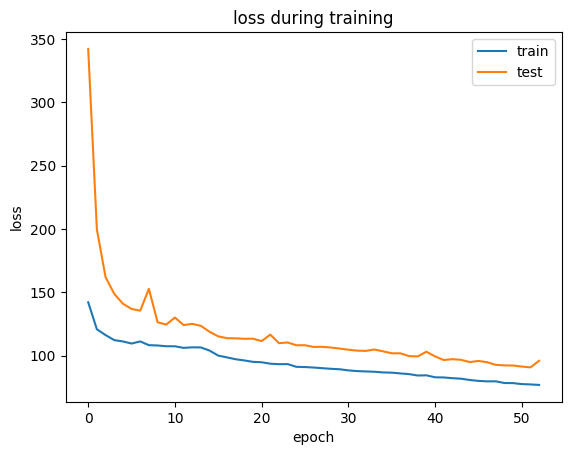

epoch 53: 100%|██████████| 160/160 [00:50<00:00,  3.20it/s]


train 	 loss: 75.723  KLD beta: 0.421
test 	 loss: 89.809


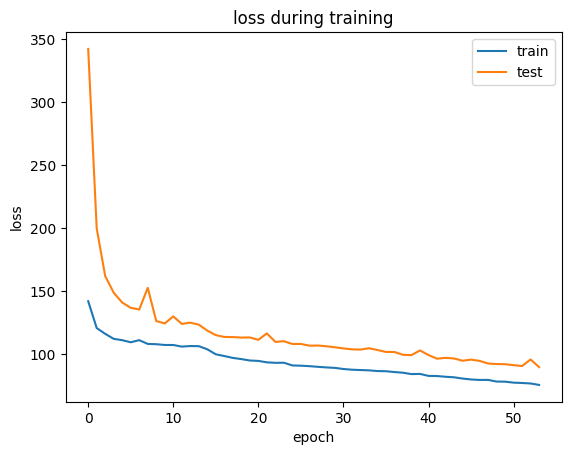

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_53.pt


epoch 54: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 75.288  KLD beta: 0.429
test 	 loss: 89.392


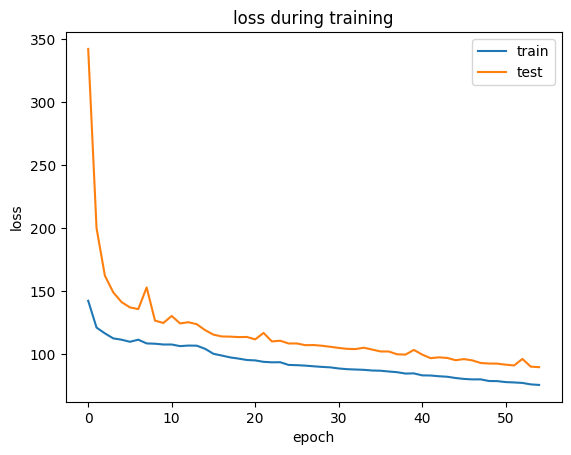

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_54.pt


epoch 55: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 74.593  KLD beta: 0.437
test 	 loss: 87.948


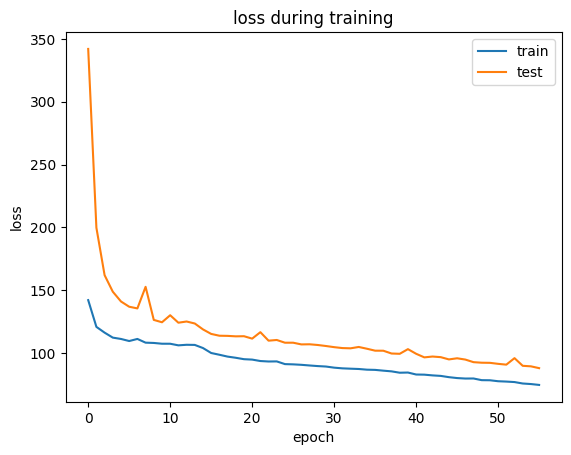

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_55.pt


epoch 56: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 74.744  KLD beta: 0.445
test 	 loss: 88.832


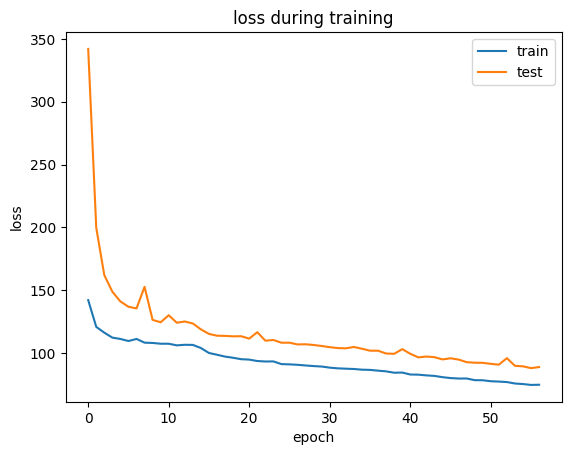

epoch 57: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 73.726  KLD beta: 0.453
test 	 loss: 87.758


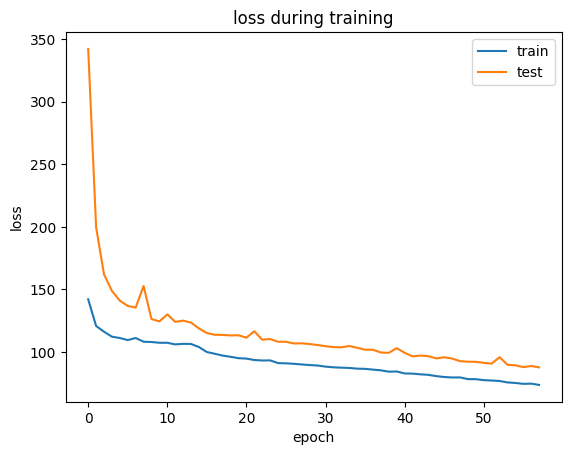

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_57.pt


epoch 58: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 73.171  KLD beta: 0.461
test 	 loss: 88.344


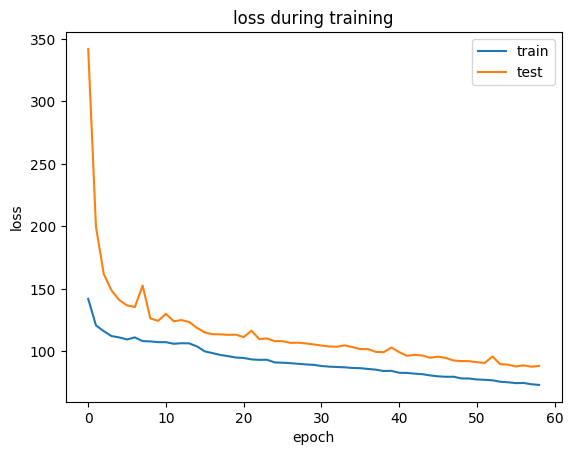

epoch 59: 100%|██████████| 160/160 [00:49<00:00,  3.20it/s]


train 	 loss: 72.299  KLD beta: 0.469
test 	 loss: 85.897


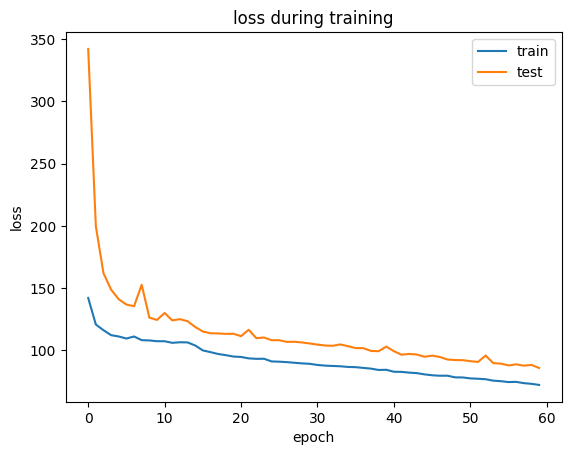

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_59.pt


epoch 60: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 71.934  KLD beta: 0.477
test 	 loss: 85.357


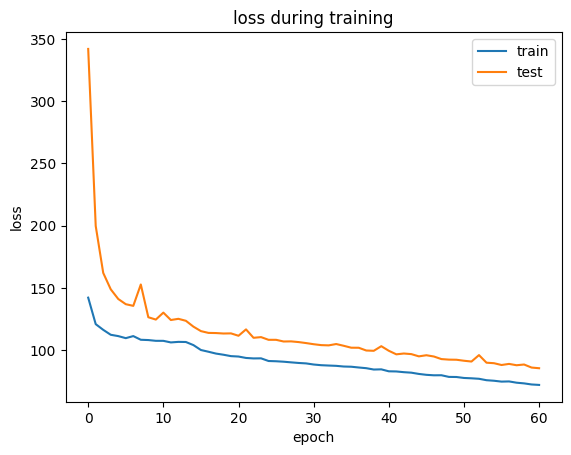

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_60.pt


epoch 61: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 71.370  KLD beta: 0.485
test 	 loss: 86.924


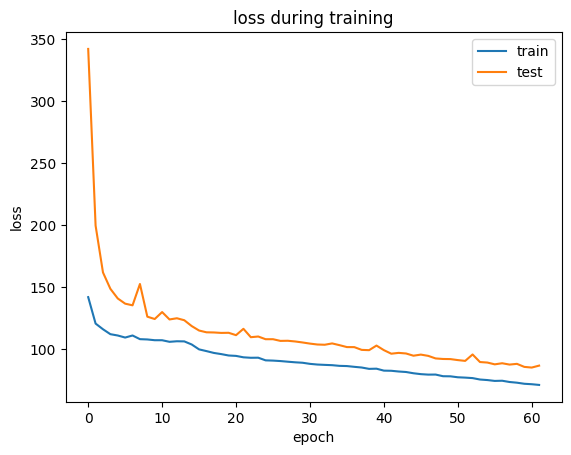

epoch 62: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 70.712  KLD beta: 0.493
test 	 loss: 85.711


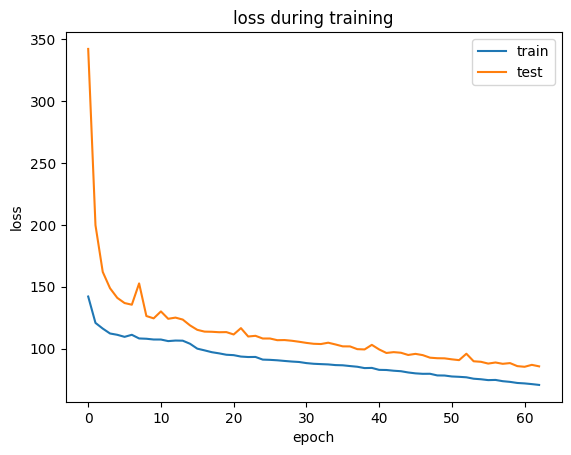

epoch 63: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 70.473  KLD beta: 0.501
test 	 loss: 83.591


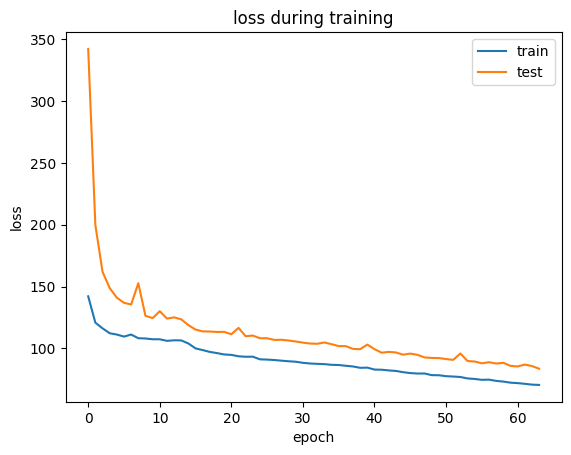

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_63.pt


epoch 64: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 70.567  KLD beta: 0.509
test 	 loss: 87.452


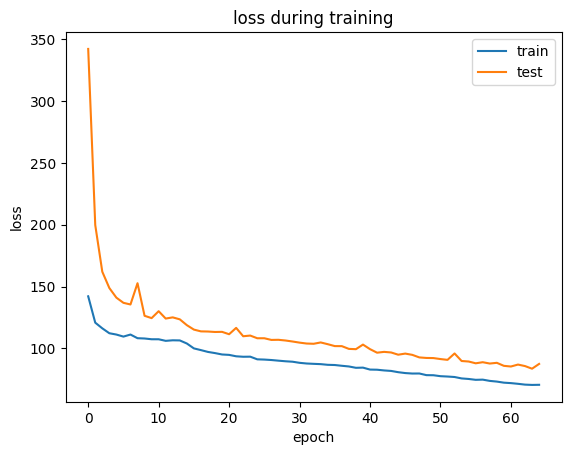

epoch 65: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 69.945  KLD beta: 0.517
test 	 loss: 83.336


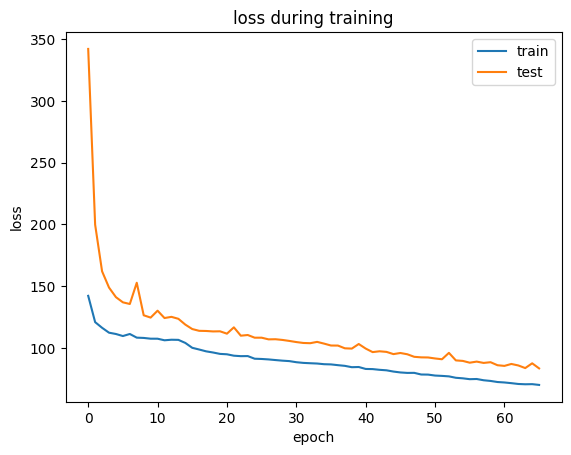

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_65.pt


epoch 66: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 68.958  KLD beta: 0.525
test 	 loss: 84.691


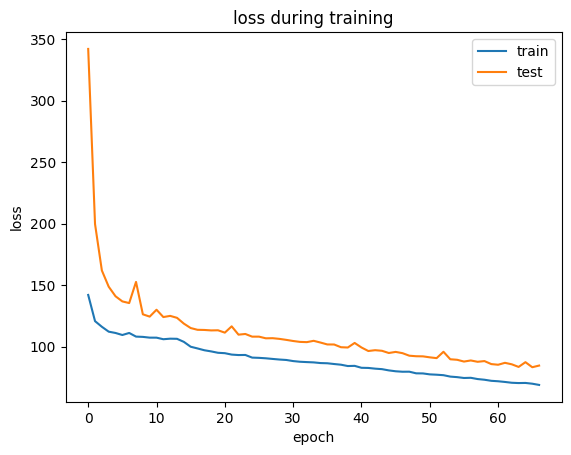

epoch 67: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 68.974  KLD beta: 0.533
test 	 loss: 82.009


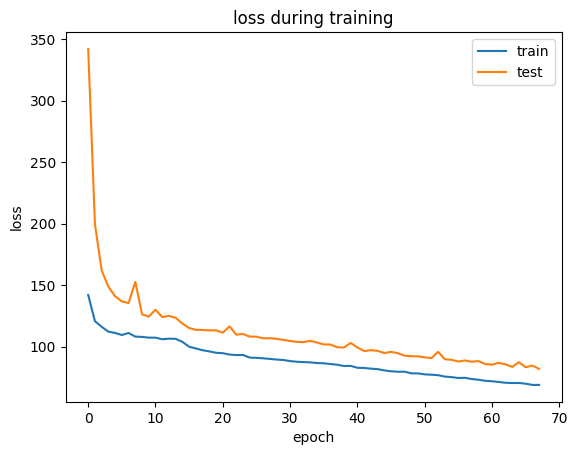

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_67.pt


epoch 68: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 68.335  KLD beta: 0.541
test 	 loss: 81.624


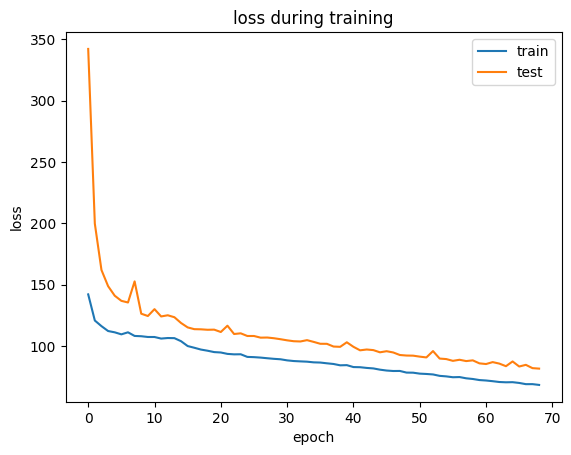

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_68.pt


epoch 69: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 68.175  KLD beta: 0.549
test 	 loss: 80.546


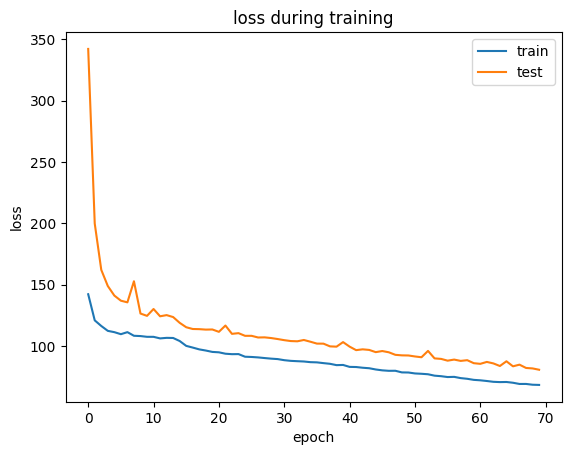

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_69.pt


epoch 70: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 67.573  KLD beta: 0.556
test 	 loss: 80.442


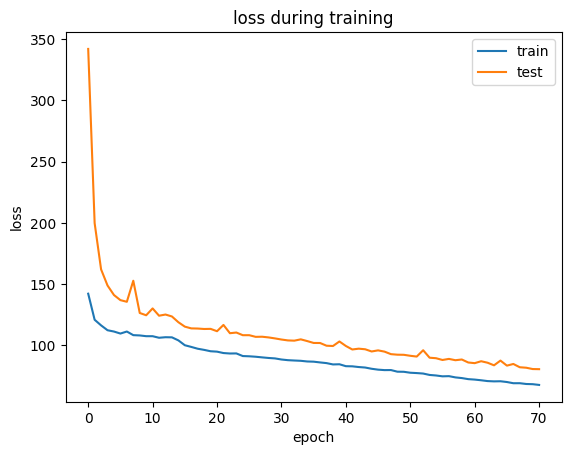

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_70.pt


epoch 71: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 67.729  KLD beta: 0.564
test 	 loss: 80.381


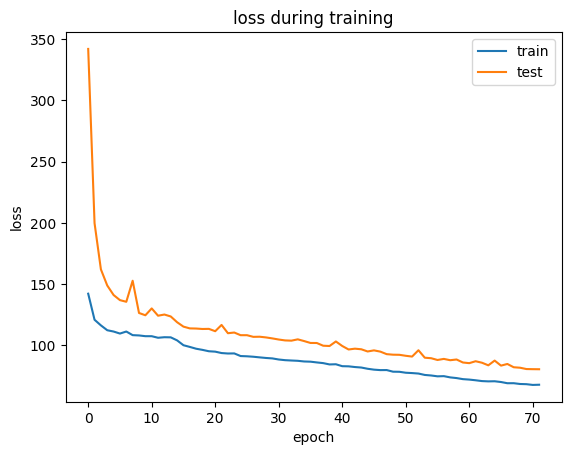

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_71.pt


epoch 72: 100%|██████████| 160/160 [00:49<00:00,  3.22it/s]


train 	 loss: 67.165  KLD beta: 0.572
test 	 loss: 80.148


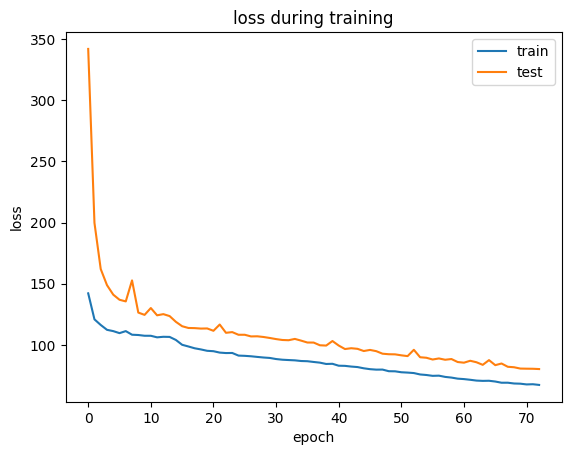

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_72.pt


epoch 73: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 66.898  KLD beta: 0.580
test 	 loss: 80.811


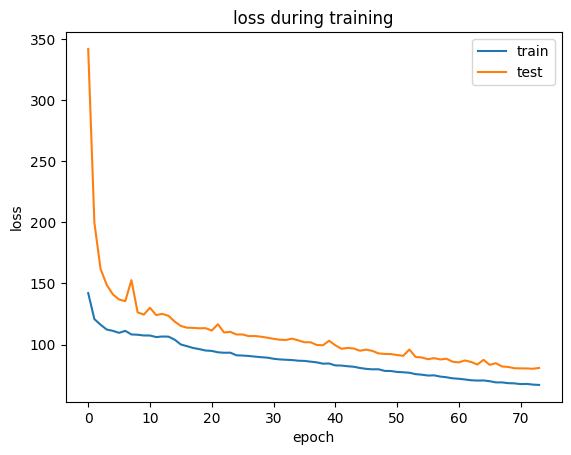

epoch 74: 100%|██████████| 160/160 [00:49<00:00,  3.24it/s]


train 	 loss: 66.752  KLD beta: 0.588
test 	 loss: 78.833


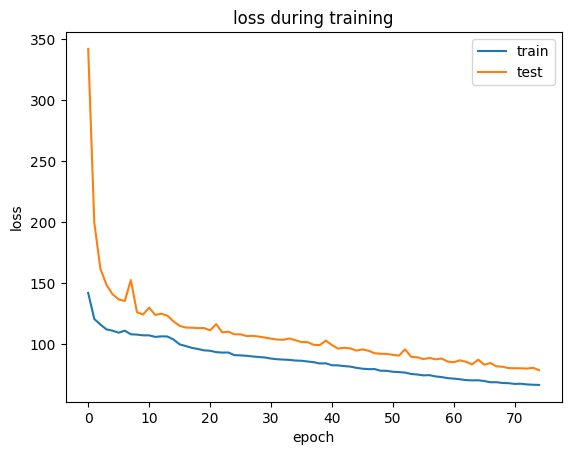

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_74.pt


epoch 75: 100%|██████████| 160/160 [00:49<00:00,  3.24it/s]


train 	 loss: 66.354  KLD beta: 0.596
test 	 loss: 77.944


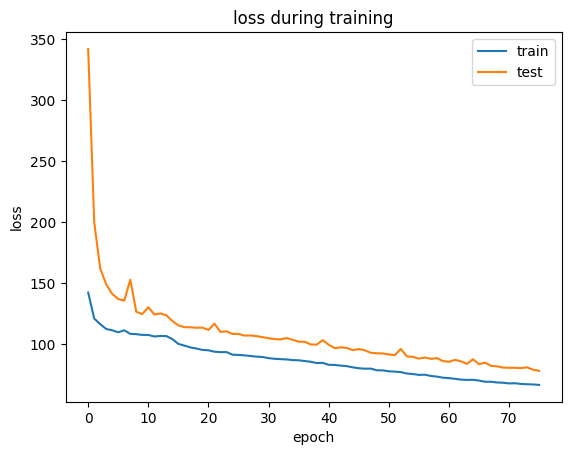

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_75.pt


epoch 76: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 65.645  KLD beta: 0.604
test 	 loss: 78.259


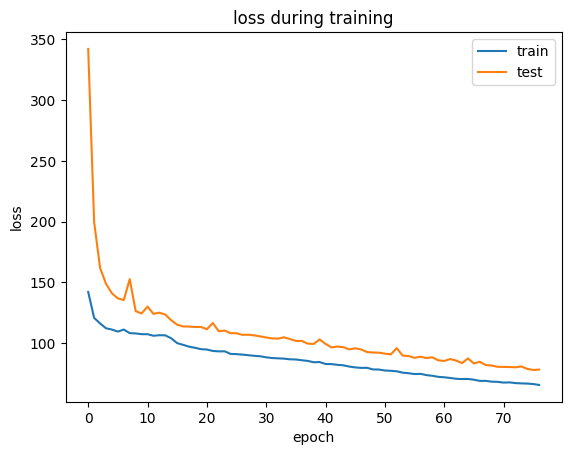

epoch 77: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


train 	 loss: 65.360  KLD beta: 0.612
test 	 loss: 78.354


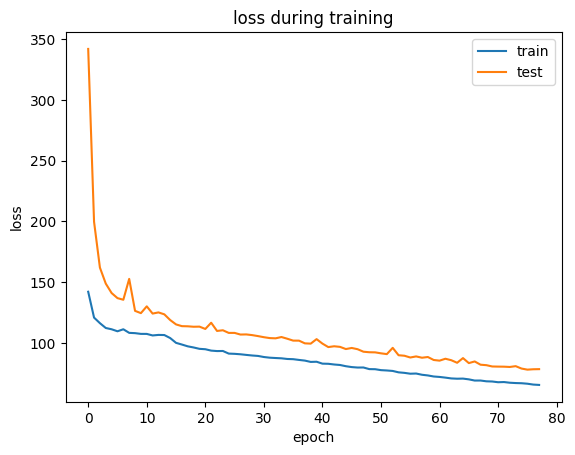

epoch 78: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 65.520  KLD beta: 0.620
test 	 loss: 77.672


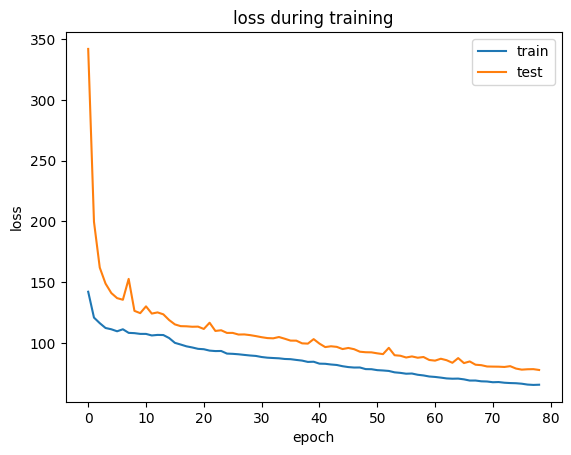

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_78.pt


epoch 79: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 65.159  KLD beta: 0.628
test 	 loss: 79.702


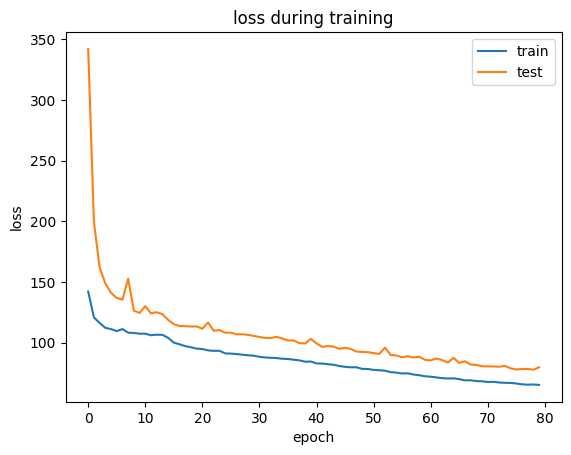

epoch 80: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


train 	 loss: 64.460  KLD beta: 0.636
test 	 loss: 76.955


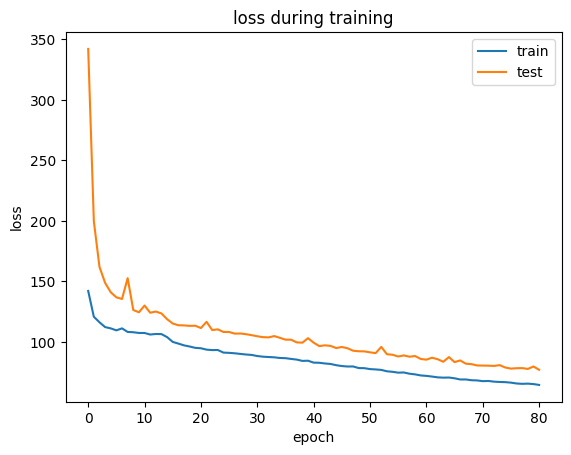

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_80.pt


epoch 81: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 64.609  KLD beta: 0.644
test 	 loss: 76.795


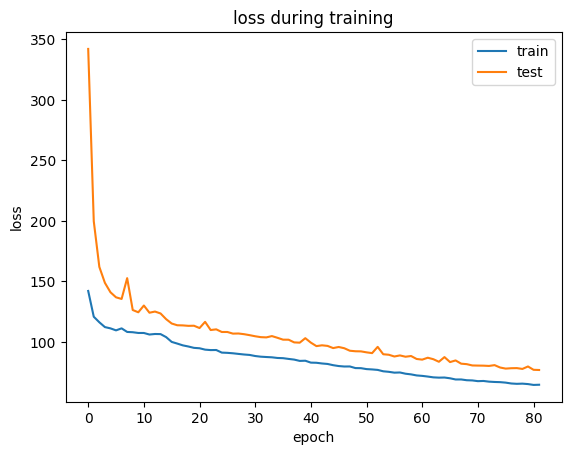

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_81.pt


epoch 82: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 65.704  KLD beta: 0.652
test 	 loss: 76.975


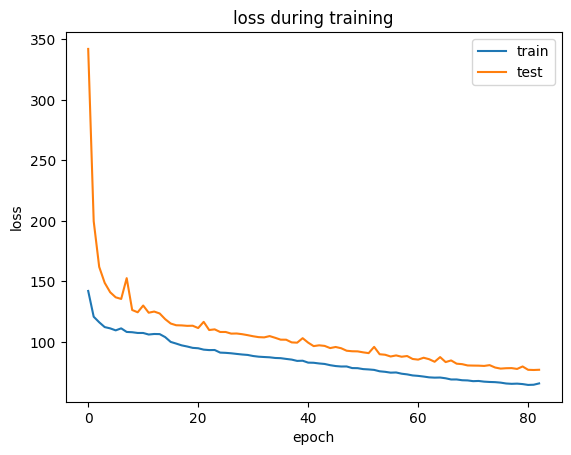

epoch 83: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 64.181  KLD beta: 0.660
test 	 loss: 76.183


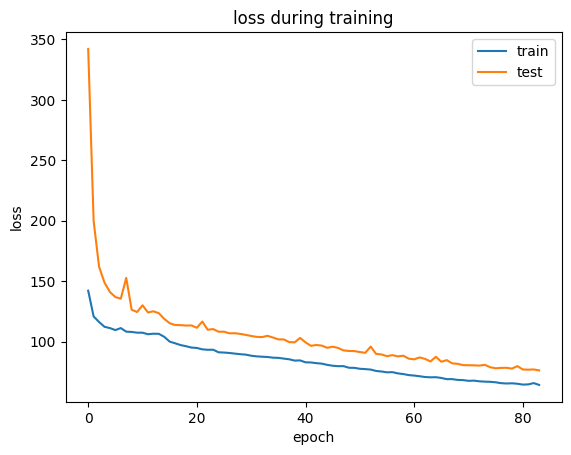

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_83.pt


epoch 84: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 64.065  KLD beta: 0.668
test 	 loss: 75.770


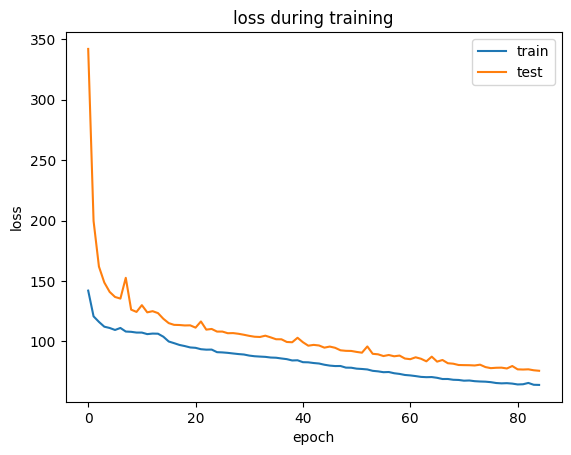

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_84.pt


epoch 85: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


train 	 loss: 65.343  KLD beta: 0.676
test 	 loss: 81.911


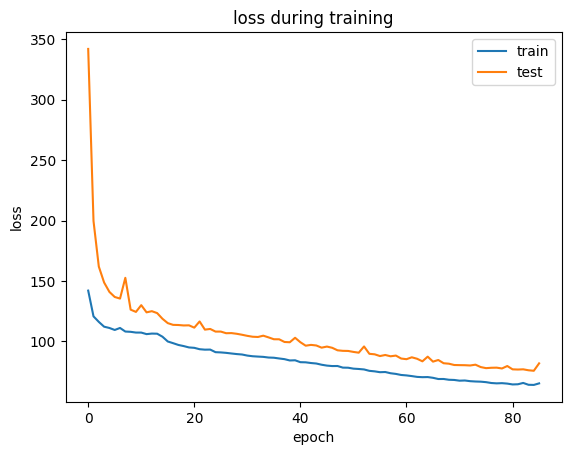

epoch 86: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


train 	 loss: 64.715  KLD beta: 0.684
test 	 loss: 77.121


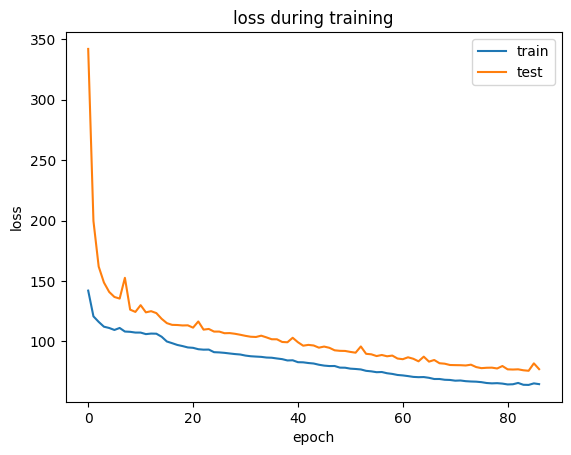

epoch 87: 100%|██████████| 160/160 [00:49<00:00,  3.23it/s]


train 	 loss: 63.382  KLD beta: 0.692
test 	 loss: 74.425


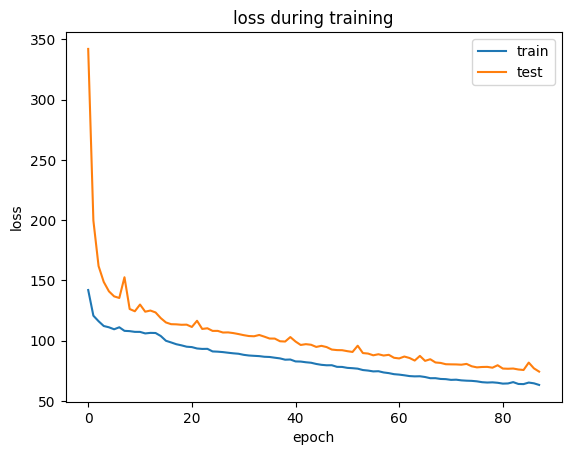

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_87.pt


epoch 88: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


train 	 loss: 63.085  KLD beta: 0.700
test 	 loss: 75.642


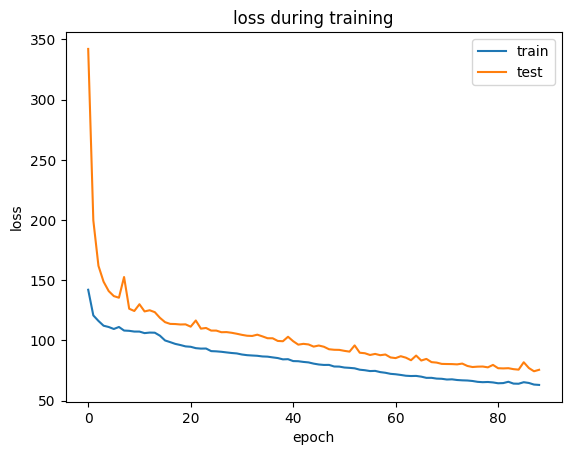

epoch 89: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


train 	 loss: 63.088  KLD beta: 0.708
test 	 loss: 74.295


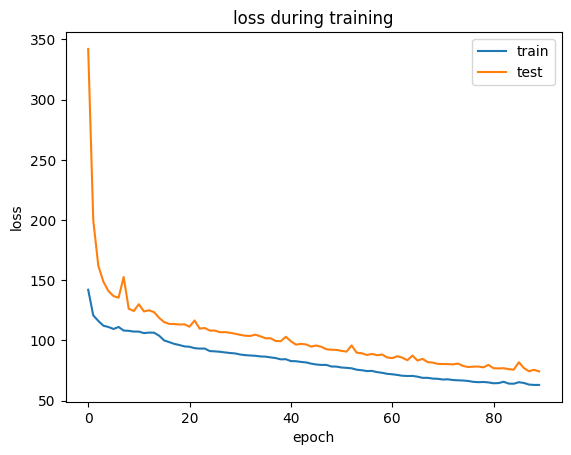

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_89.pt


epoch 90: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 62.803  KLD beta: 0.715
test 	 loss: 76.990


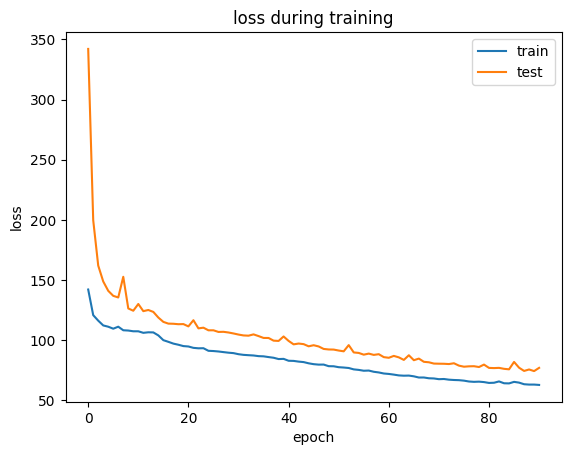

epoch 91: 100%|██████████| 160/160 [00:49<00:00,  3.24it/s]


train 	 loss: 62.774  KLD beta: 0.723
test 	 loss: 73.976


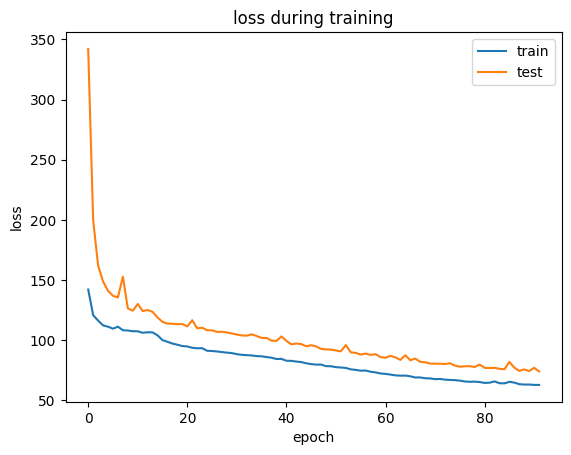

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_91.pt


epoch 92: 100%|██████████| 160/160 [00:49<00:00,  3.24it/s]


train 	 loss: 61.914  KLD beta: 0.731
test 	 loss: 74.310


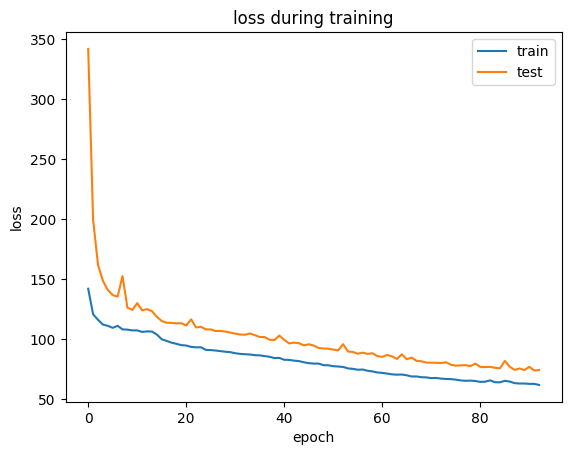

epoch 93: 100%|██████████| 160/160 [00:49<00:00,  3.25it/s]


train 	 loss: 62.402  KLD beta: 0.739
test 	 loss: 74.714


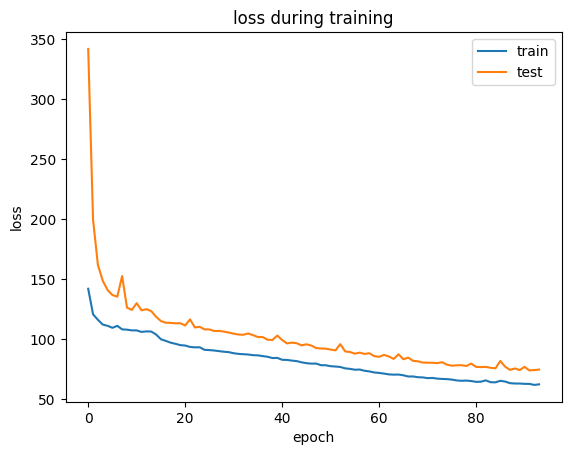

epoch 94: 100%|██████████| 160/160 [00:49<00:00,  3.27it/s]


train 	 loss: 61.948  KLD beta: 0.747
test 	 loss: 74.781


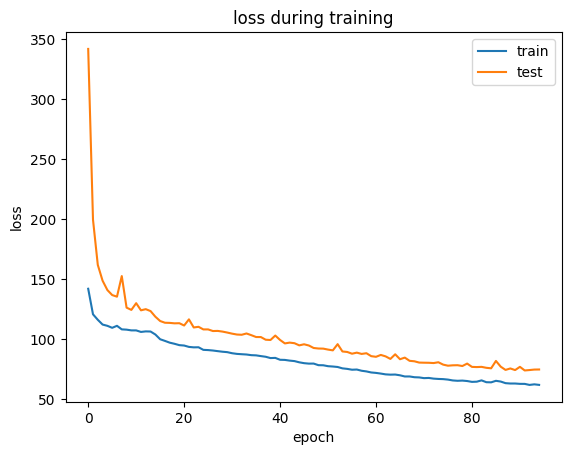

epoch 95: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 62.234  KLD beta: 0.755
test 	 loss: 73.187


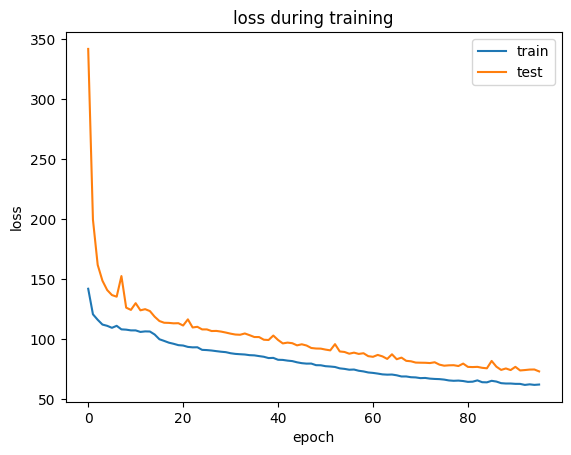

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_95.pt


epoch 96: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 61.797  KLD beta: 0.763
test 	 loss: 72.103


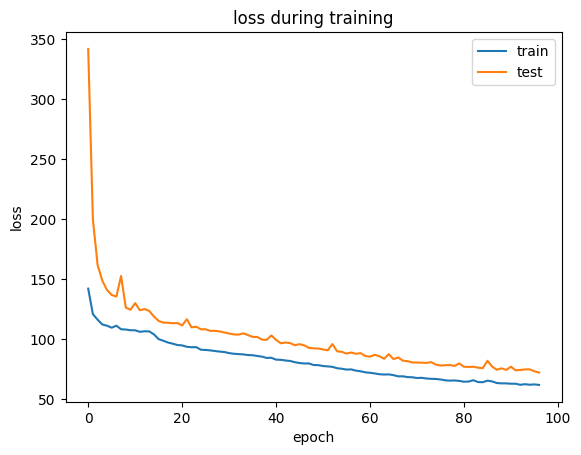

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_96.pt


epoch 97: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 61.810  KLD beta: 0.771
test 	 loss: 73.788


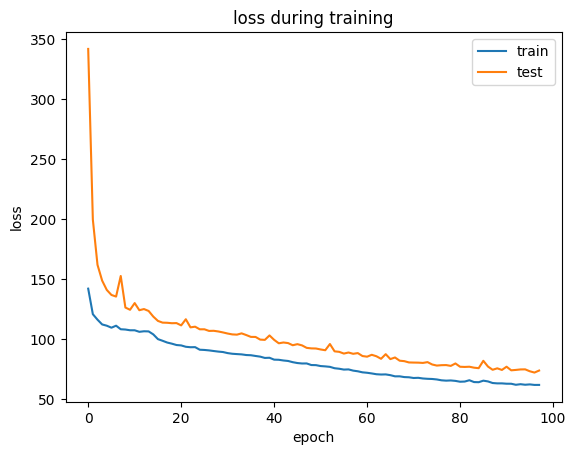

epoch 98: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 61.362  KLD beta: 0.779
test 	 loss: 72.763


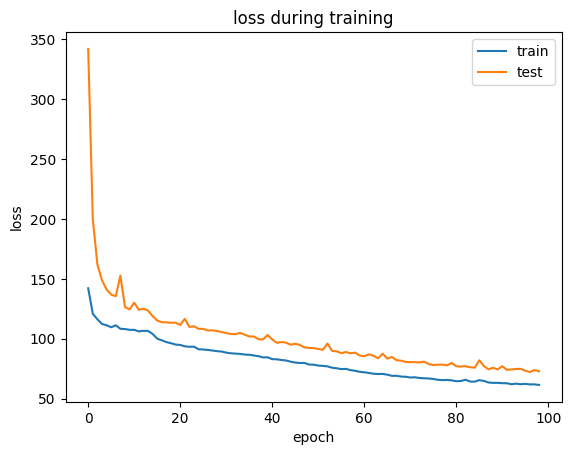

epoch 99: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 61.387  KLD beta: 0.787
test 	 loss: 72.634


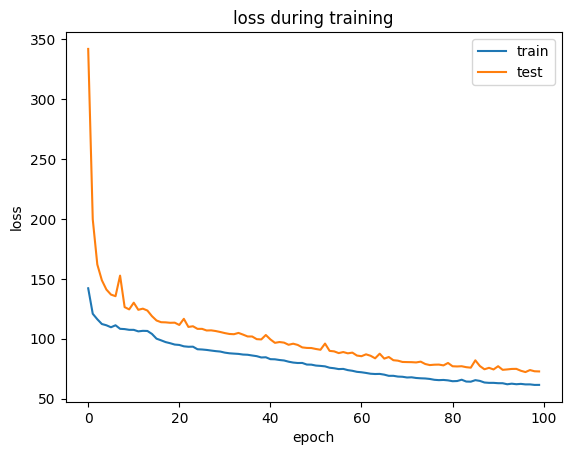

epoch 100: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 61.160  KLD beta: 0.795
test 	 loss: 71.749


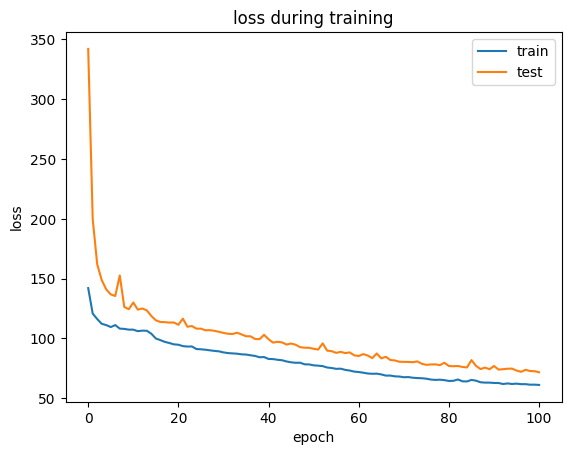

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_100.pt


epoch 101: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 60.814  KLD beta: 0.803
test 	 loss: 73.587


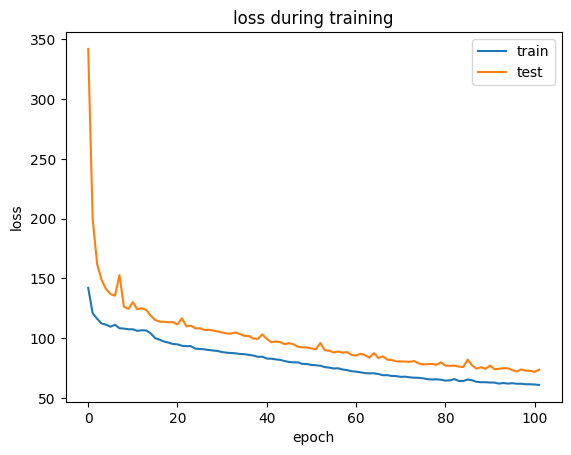

epoch 102: 100%|██████████| 160/160 [00:49<00:00,  3.26it/s]


train 	 loss: 60.882  KLD beta: 0.811
test 	 loss: 71.922


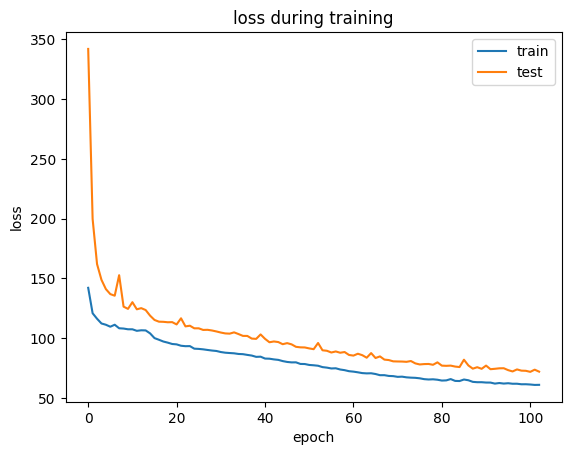

epoch 103: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 60.526  KLD beta: 0.819
test 	 loss: 71.650


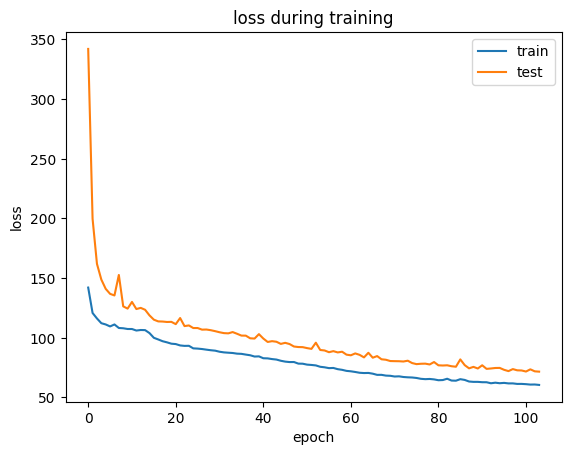

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_103.pt


epoch 104: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 60.337  KLD beta: 0.827
test 	 loss: 71.268


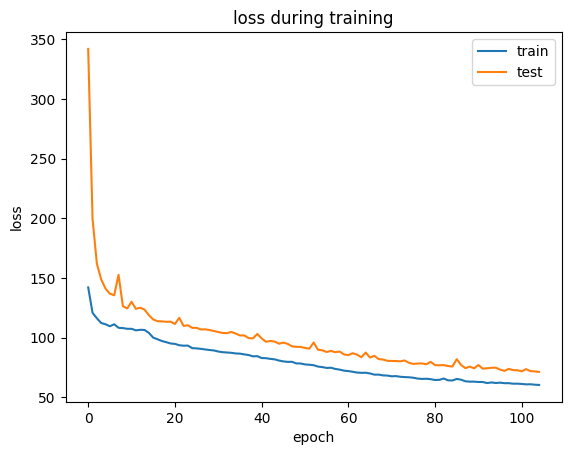

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_104.pt


epoch 105: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 60.192  KLD beta: 0.835
test 	 loss: 72.244


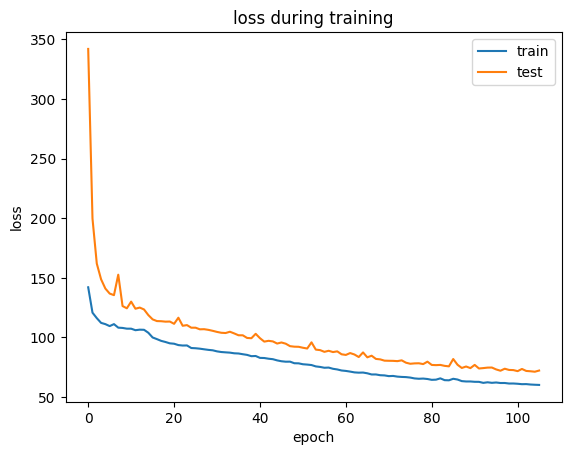

epoch 106: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.963  KLD beta: 0.843
test 	 loss: 72.780


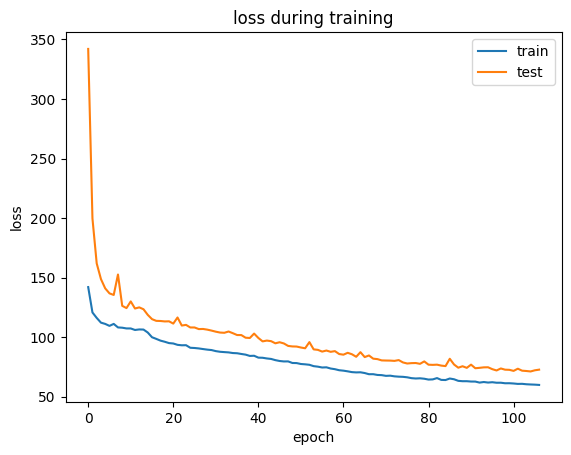

epoch 107: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 61.552  KLD beta: 0.851
test 	 loss: 71.511


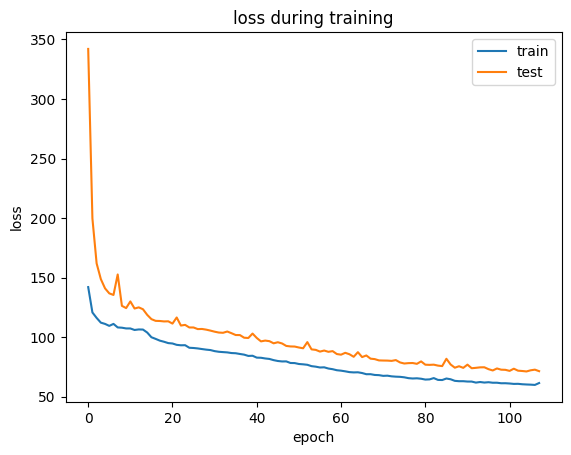

epoch 108: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 59.936  KLD beta: 0.859
test 	 loss: 71.206


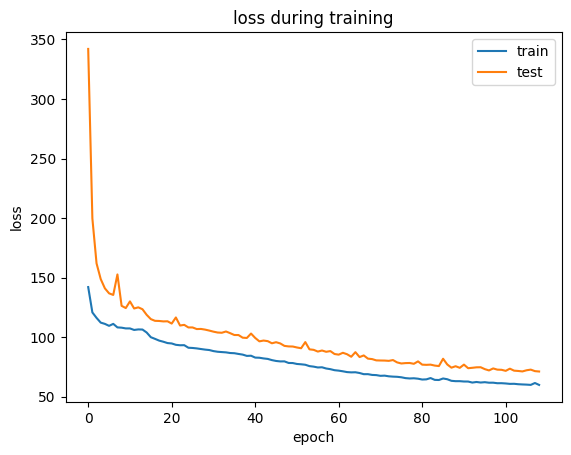

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_108.pt


epoch 109: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 59.795  KLD beta: 0.867
test 	 loss: 70.660


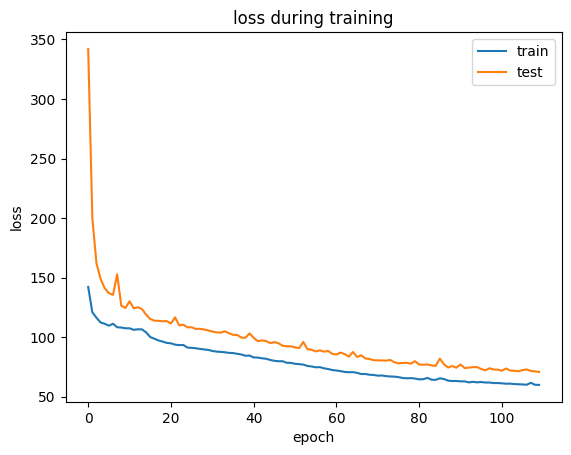

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_109.pt


epoch 110: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 59.960  KLD beta: 0.874
test 	 loss: 73.167


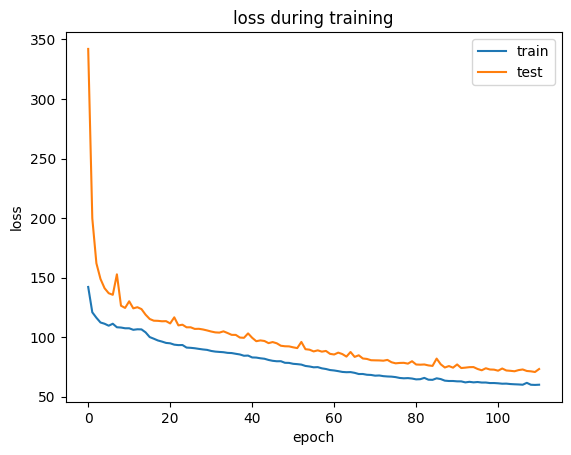

epoch 111: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.306  KLD beta: 0.882
test 	 loss: 69.942


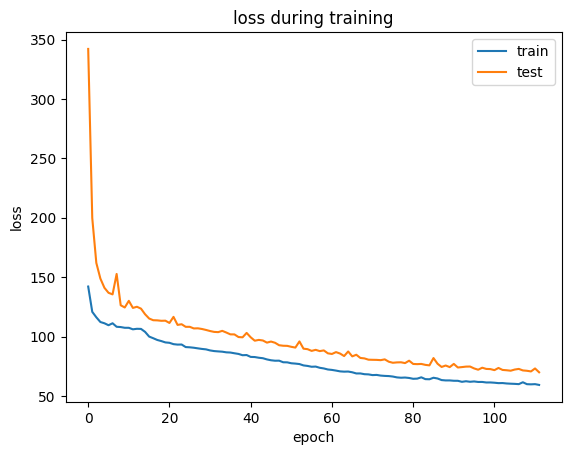

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_111.pt


epoch 112: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.771  KLD beta: 0.890
test 	 loss: 69.522


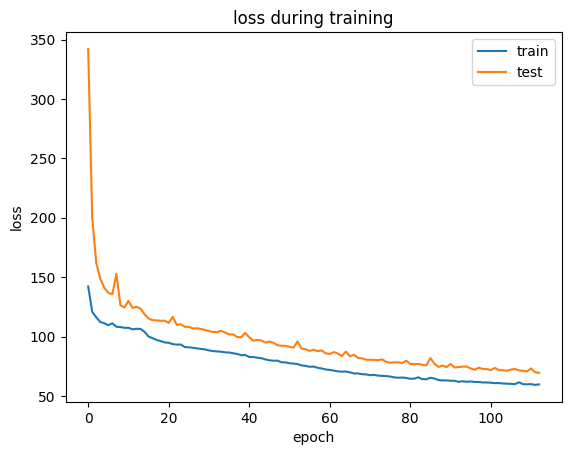

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_112.pt


epoch 113: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.694  KLD beta: 0.898
test 	 loss: 72.553


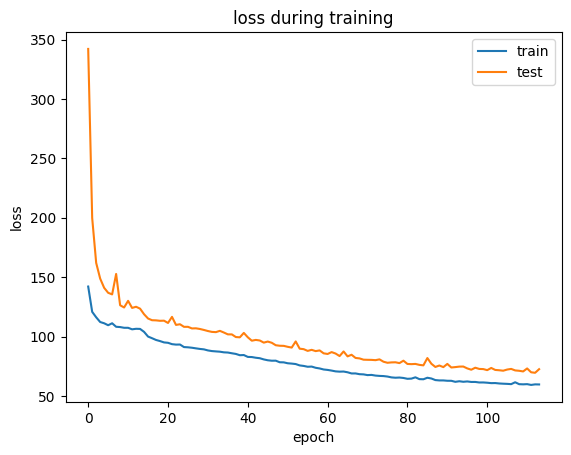

epoch 114: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 59.275  KLD beta: 0.906
test 	 loss: 69.395


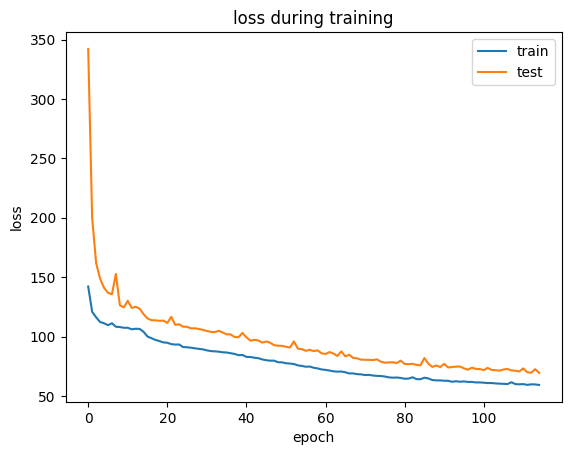

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_114.pt


epoch 115: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 59.241  KLD beta: 0.914
test 	 loss: 70.071


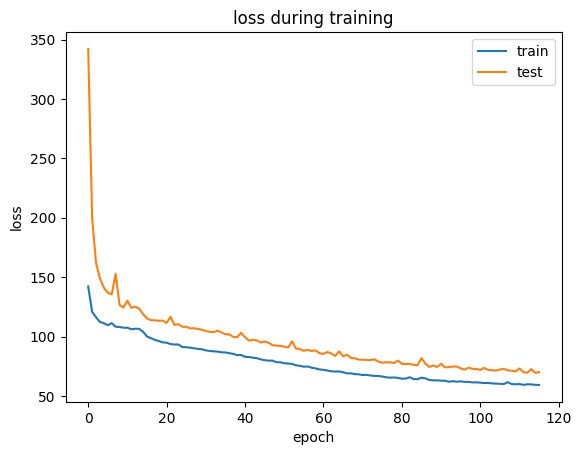

epoch 116: 100%|██████████| 160/160 [00:48<00:00,  3.27it/s]


train 	 loss: 59.645  KLD beta: 0.922
test 	 loss: 70.593


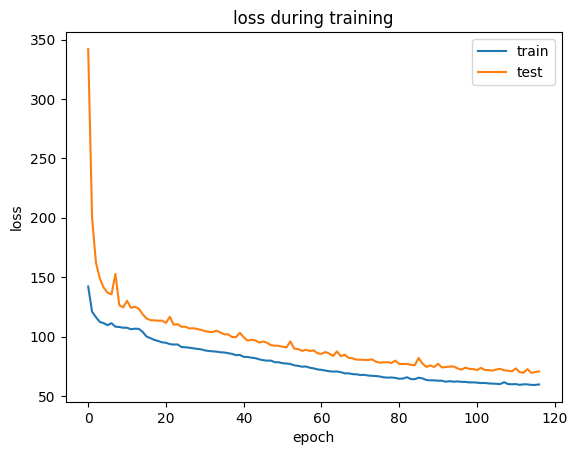

epoch 117: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.244  KLD beta: 0.930
test 	 loss: 70.485


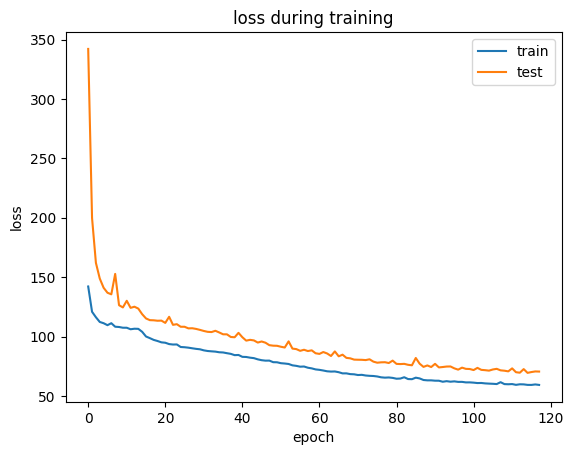

epoch 118: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.070  KLD beta: 0.938
test 	 loss: 69.864


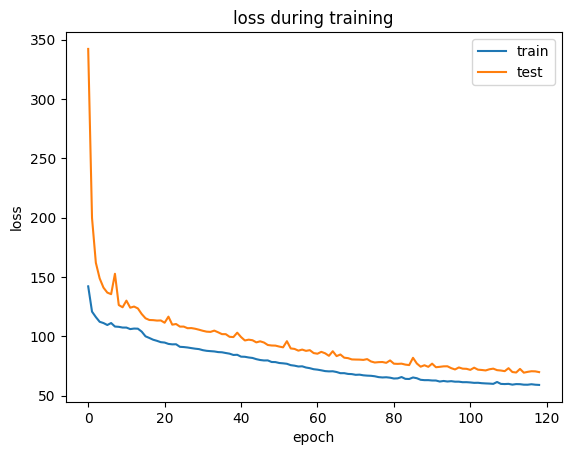

epoch 119: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.755  KLD beta: 0.946
test 	 loss: 71.207


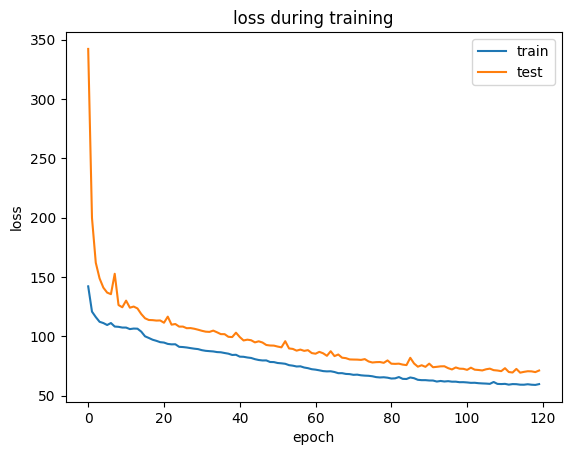

epoch 120: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 58.806  KLD beta: 0.954
test 	 loss: 70.703


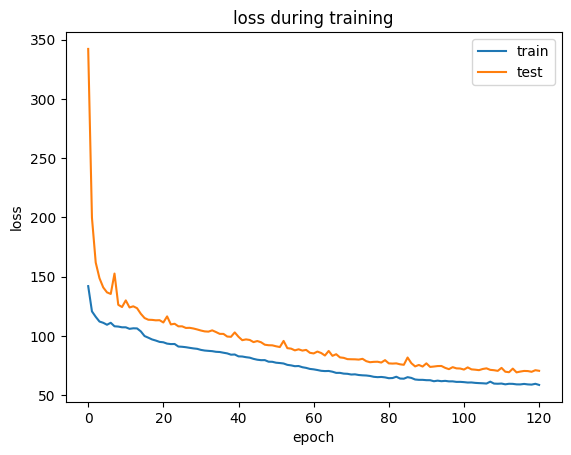

epoch 121: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 58.500  KLD beta: 0.962
test 	 loss: 69.356


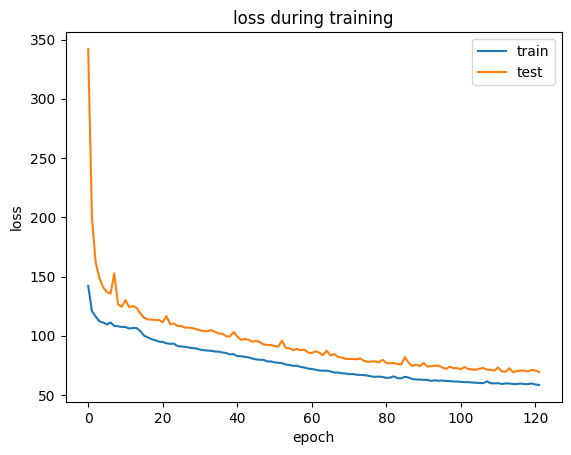

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_121.pt


epoch 122: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.552  KLD beta: 0.970
test 	 loss: 72.727


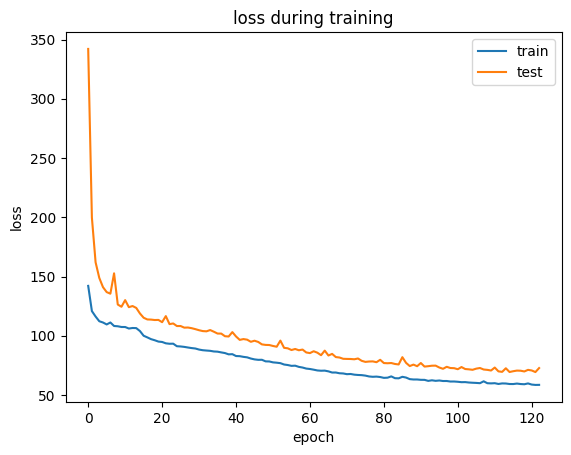

epoch 123: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.530  KLD beta: 0.978
test 	 loss: 69.046


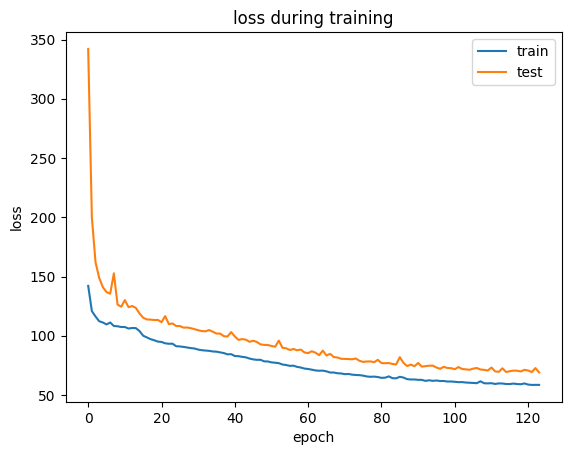

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_123.pt


epoch 124: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 58.883  KLD beta: 0.986
test 	 loss: 70.738


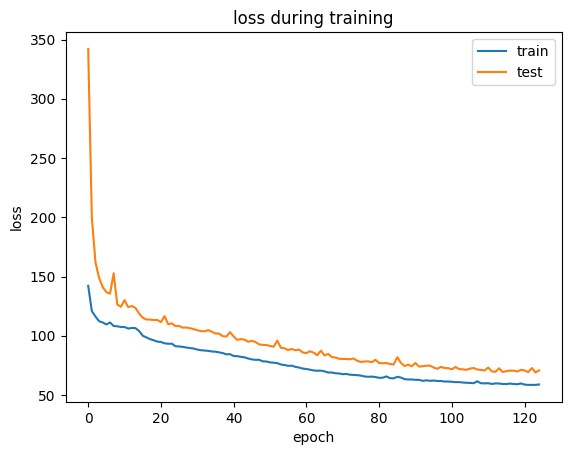

epoch 125: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 59.102  KLD beta: 0.994
test 	 loss: 69.006


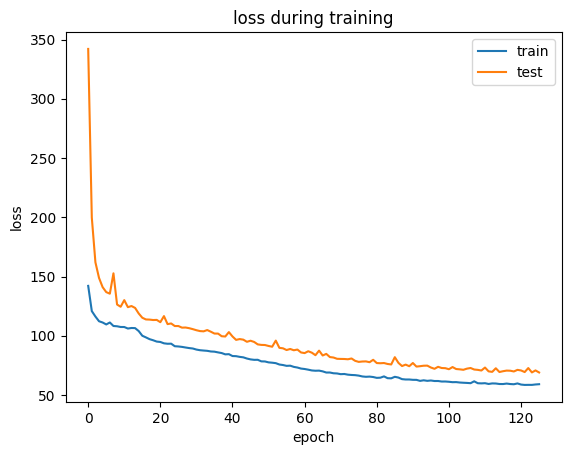

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_125.pt


epoch 126: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.069  KLD beta: 1.000
test 	 loss: 69.042


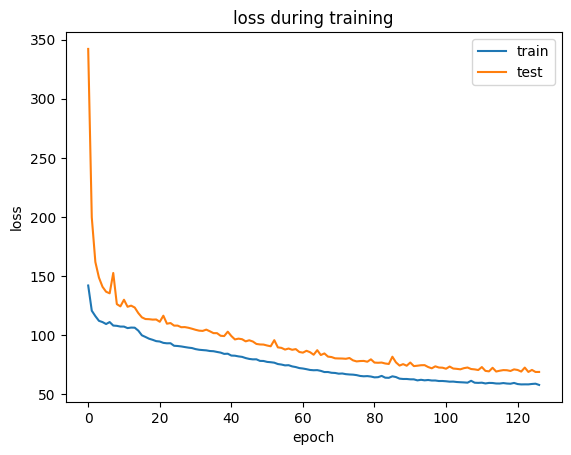

epoch 127: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 58.905  KLD beta: 1.000
test 	 loss: 70.540


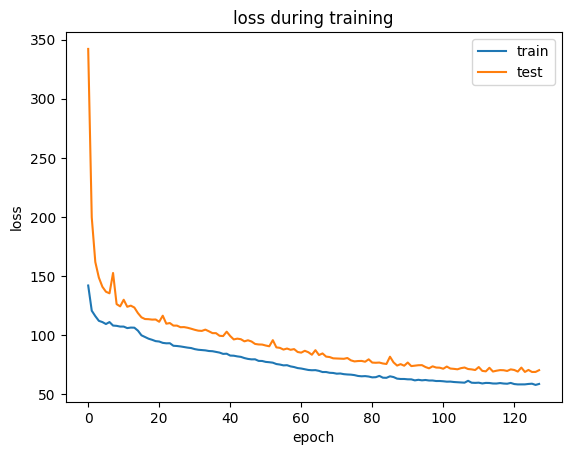

epoch 128: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.353  KLD beta: 1.000
test 	 loss: 69.444


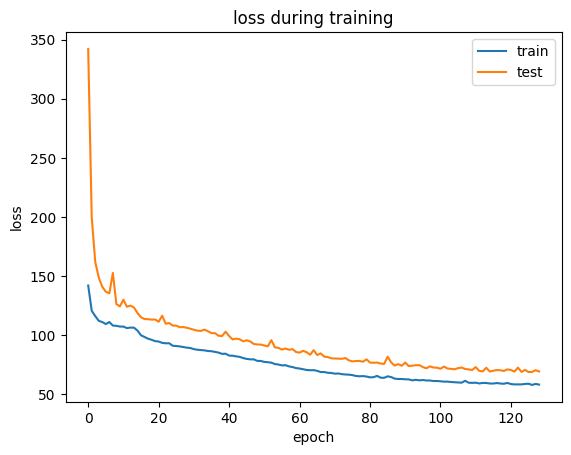

epoch 129: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 58.555  KLD beta: 1.000
test 	 loss: 69.585


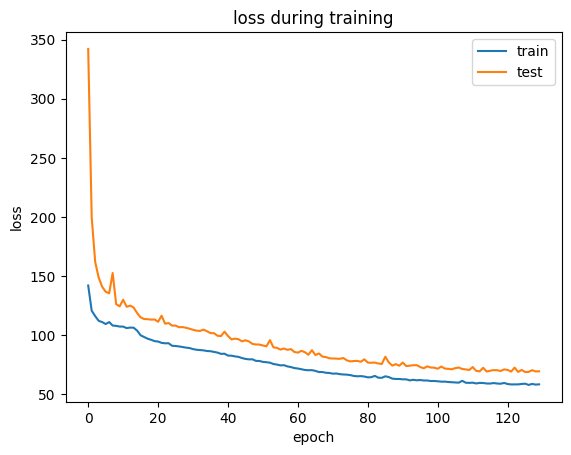

epoch 130: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 57.623  KLD beta: 1.000
test 	 loss: 68.599


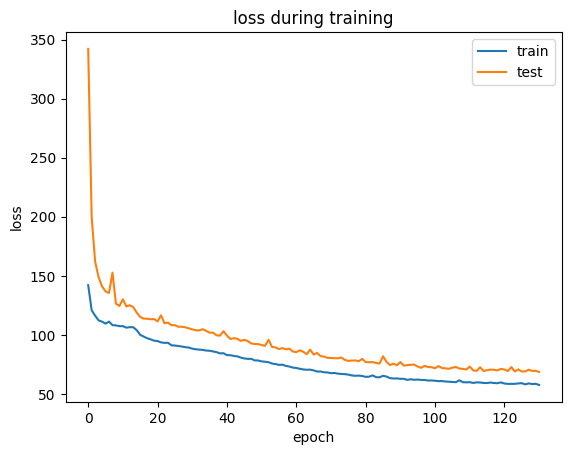

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_130.pt


epoch 131: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 58.300  KLD beta: 1.000
test 	 loss: 68.807


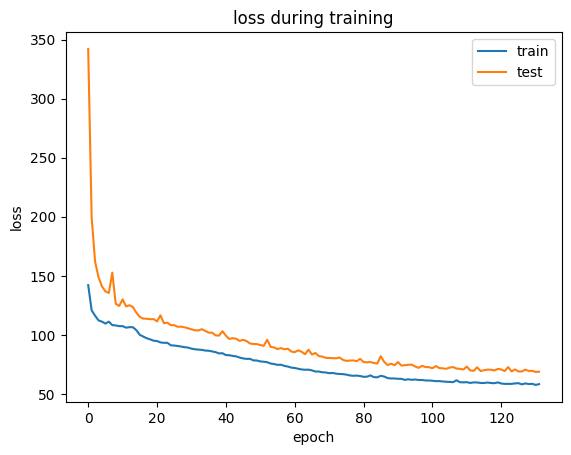

epoch 132: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.053  KLD beta: 1.000
test 	 loss: 66.933


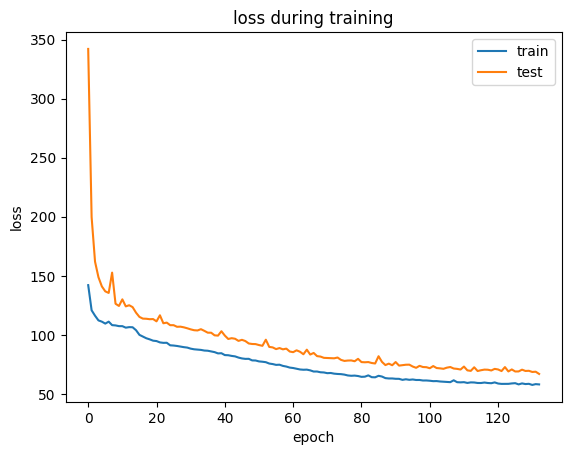

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_132.pt


epoch 133: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 57.710  KLD beta: 1.000
test 	 loss: 66.762


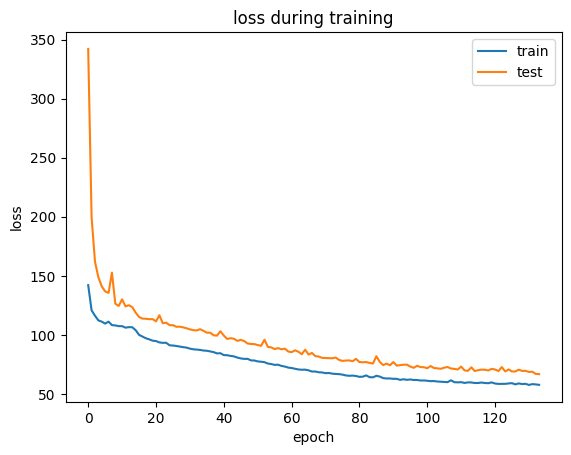

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_133.pt


epoch 134: 100%|██████████| 160/160 [00:48<00:00,  3.28it/s]


train 	 loss: 57.952  KLD beta: 1.000
test 	 loss: 68.331


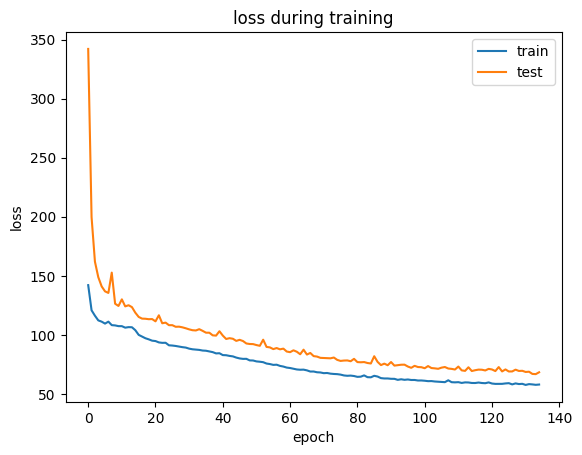

epoch 135: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.103  KLD beta: 1.000
test 	 loss: 67.441


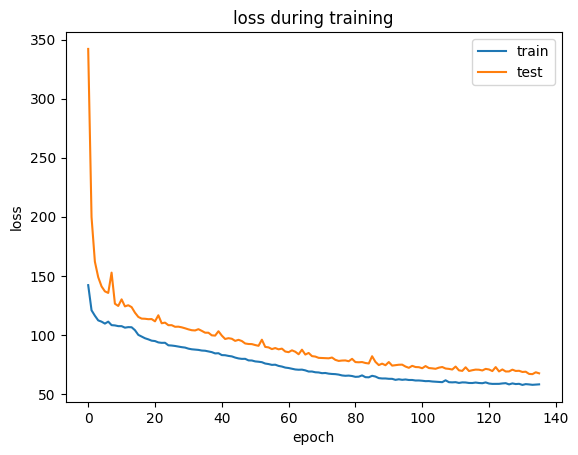

epoch 136: 100%|██████████| 160/160 [00:48<00:00,  3.31it/s]


train 	 loss: 57.762  KLD beta: 1.000
test 	 loss: 67.653


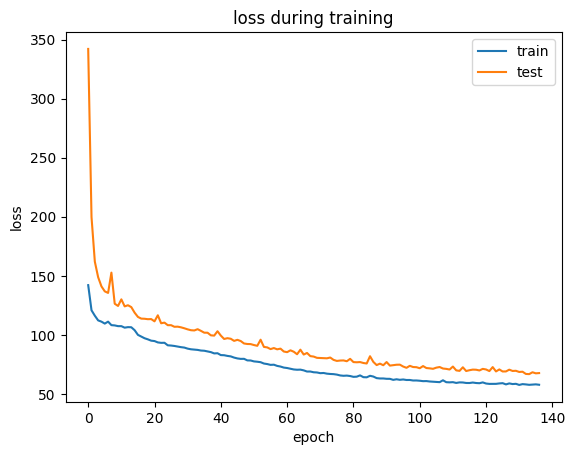

epoch 137: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.513  KLD beta: 1.000
test 	 loss: 67.414


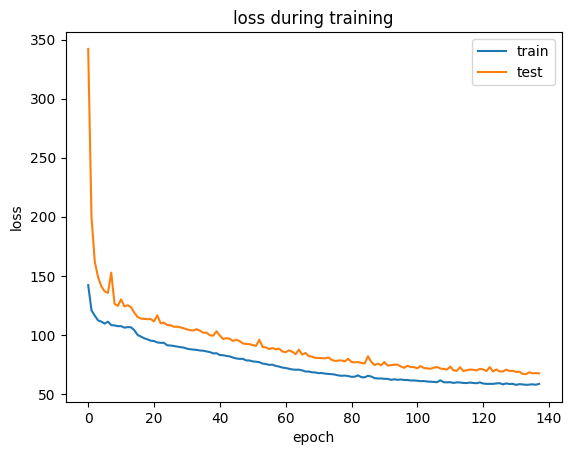

epoch 138: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 56.960  KLD beta: 1.000
test 	 loss: 66.335


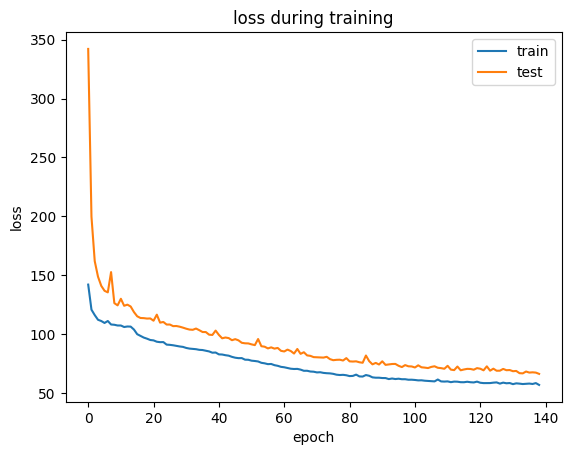

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_138.pt


epoch 139: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 57.923  KLD beta: 1.000
test 	 loss: 66.985


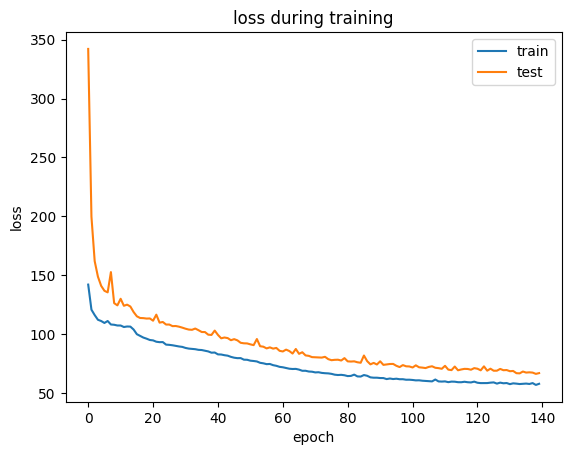

epoch 140: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.550  KLD beta: 1.000
test 	 loss: 68.728


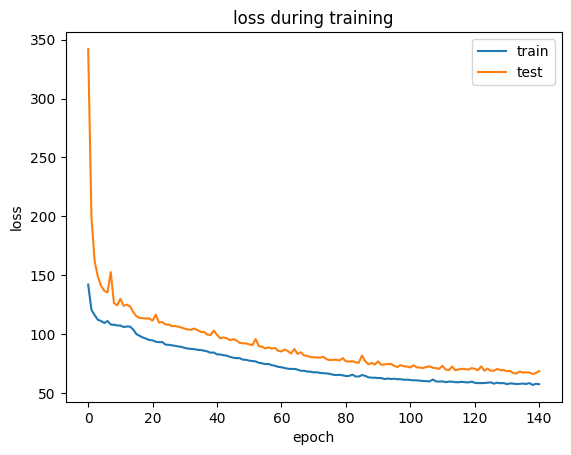

epoch 141: 100%|██████████| 160/160 [00:48<00:00,  3.31it/s]


train 	 loss: 57.731  KLD beta: 1.000
test 	 loss: 68.787


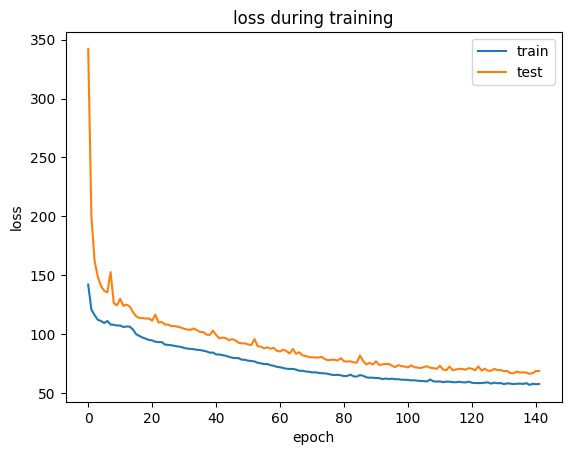

epoch 142: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 59.487  KLD beta: 1.000
test 	 loss: 72.342


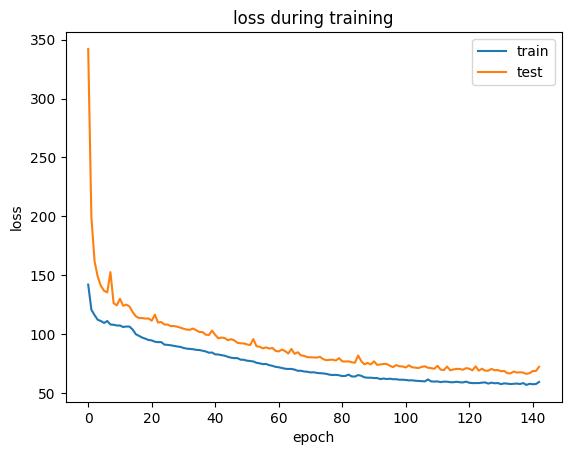

epoch 143: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 59.606  KLD beta: 1.000
test 	 loss: 70.382


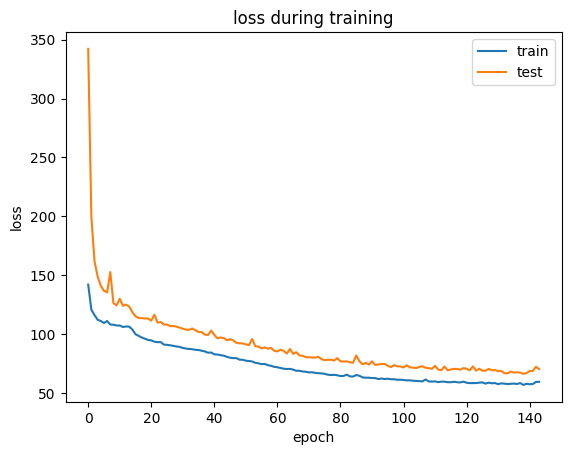

epoch 144: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 58.061  KLD beta: 1.000
test 	 loss: 66.217


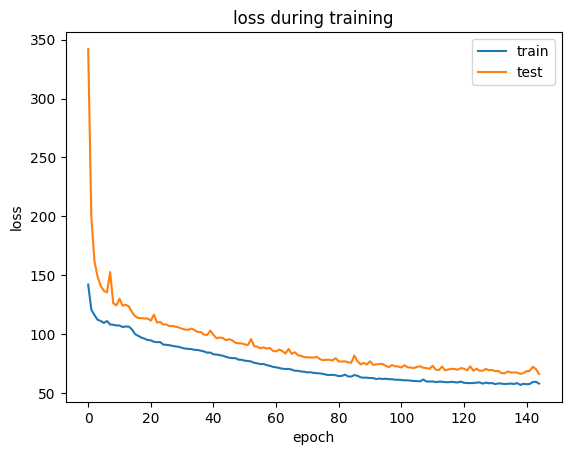

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_144.pt


epoch 145: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.226  KLD beta: 1.000
test 	 loss: 68.073


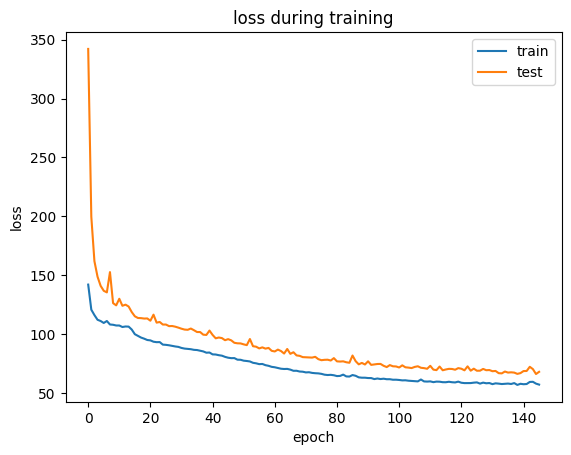

epoch 146: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 57.407  KLD beta: 1.000
test 	 loss: 66.619


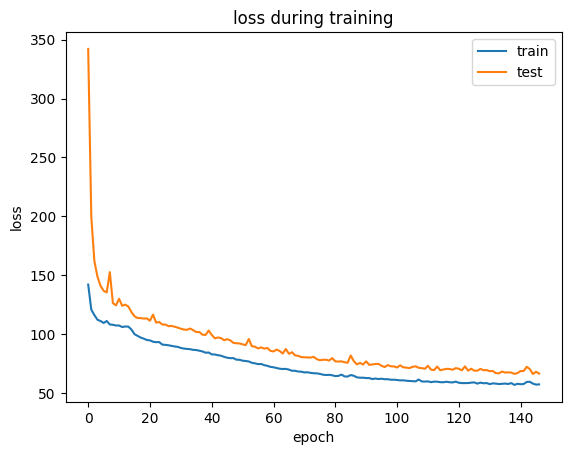

epoch 147: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 56.981  KLD beta: 1.000
test 	 loss: 66.743


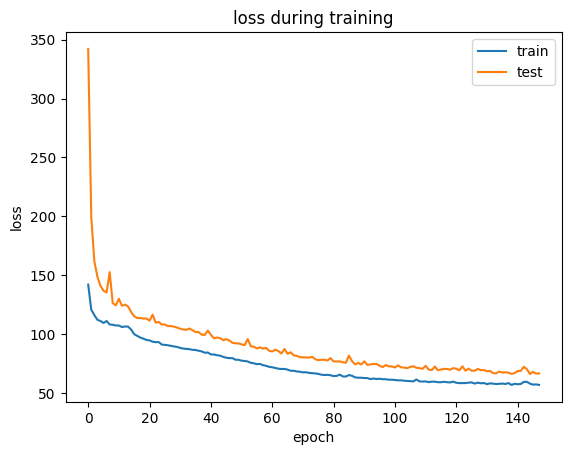

epoch 148: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.636  KLD beta: 1.000
test 	 loss: 66.806


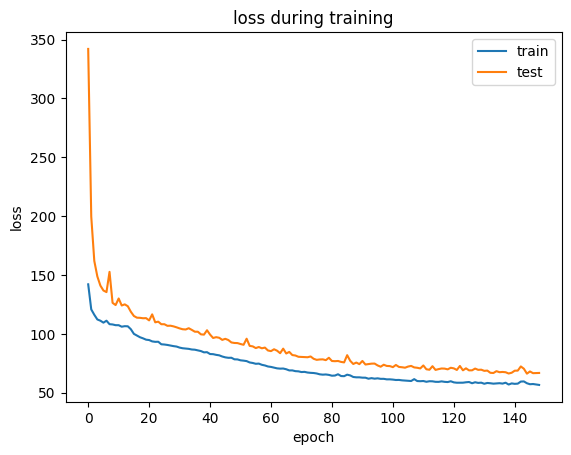

epoch 149: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.003  KLD beta: 1.000
test 	 loss: 67.960


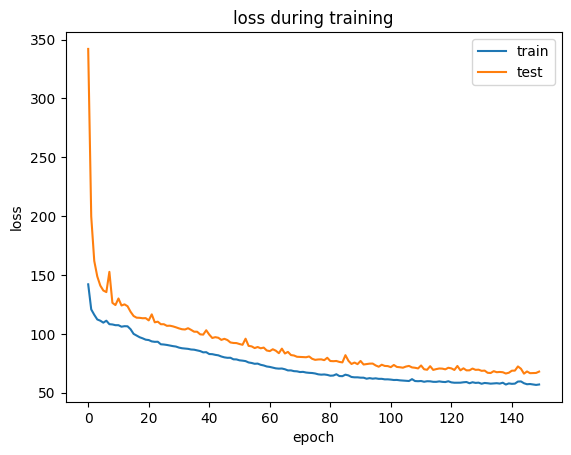

epoch 150: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 56.857  KLD beta: 1.000
test 	 loss: 65.368


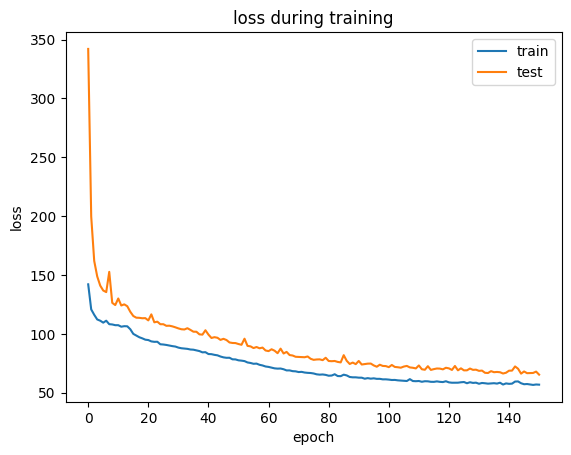

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_150.pt


epoch 151: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.818  KLD beta: 1.000
test 	 loss: 65.988


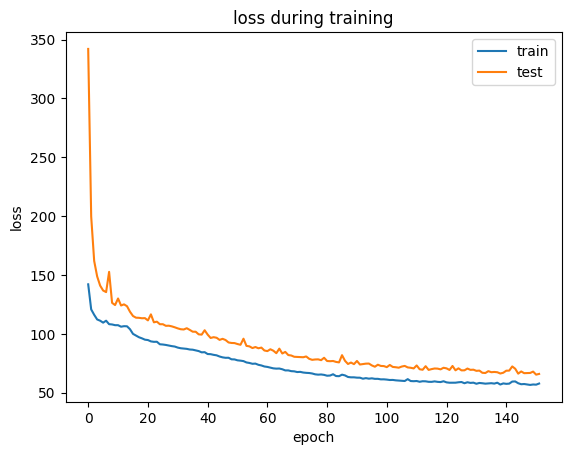

epoch 152: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.734  KLD beta: 1.000
test 	 loss: 65.357


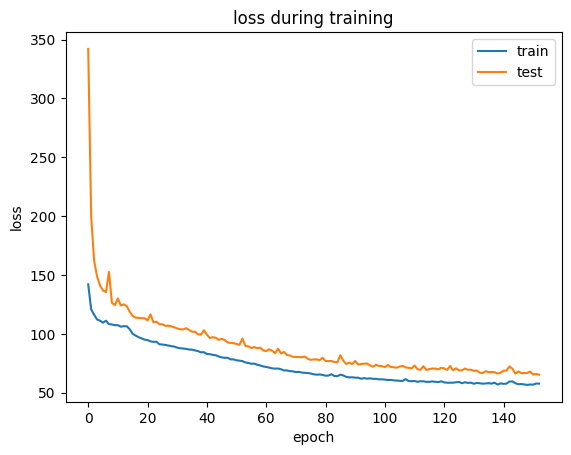

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_152.pt


epoch 153: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.206  KLD beta: 1.000
test 	 loss: 67.707


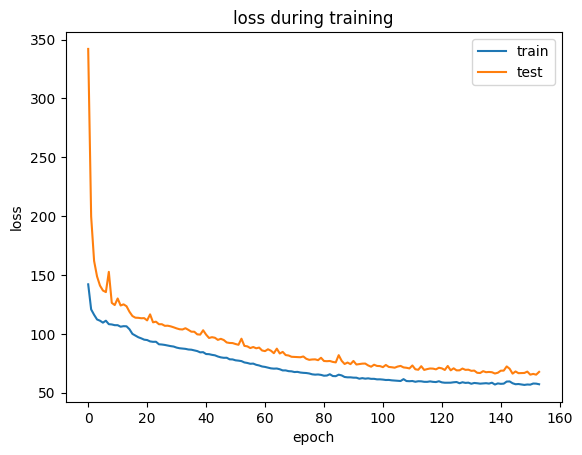

epoch 154: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 56.713  KLD beta: 1.000
test 	 loss: 68.442


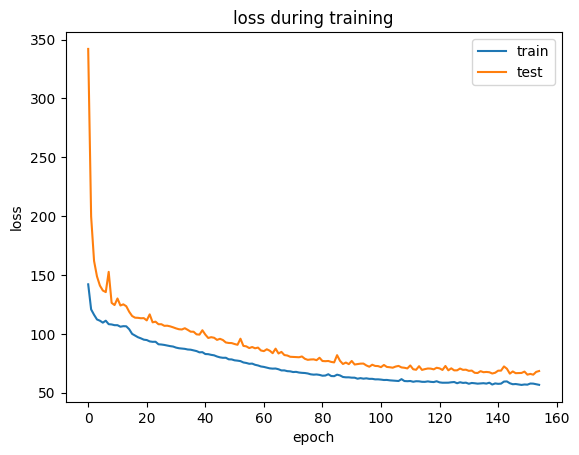

epoch 155: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.200  KLD beta: 1.000
test 	 loss: 66.544


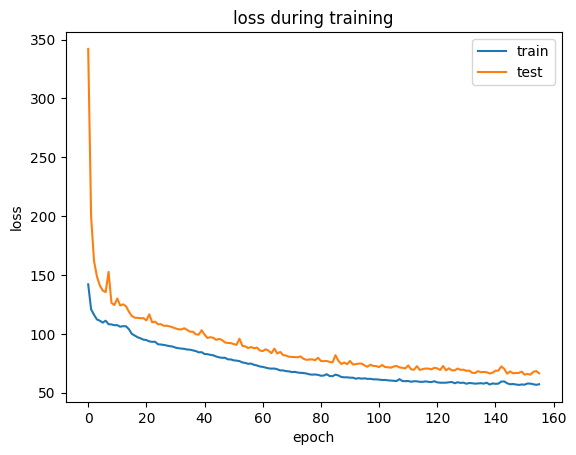

epoch 156: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 56.210  KLD beta: 1.000
test 	 loss: 64.954


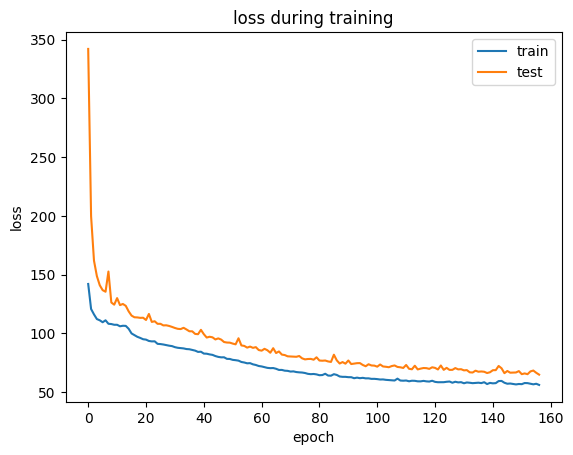

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_156.pt


epoch 157: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.042  KLD beta: 1.000
test 	 loss: 67.393


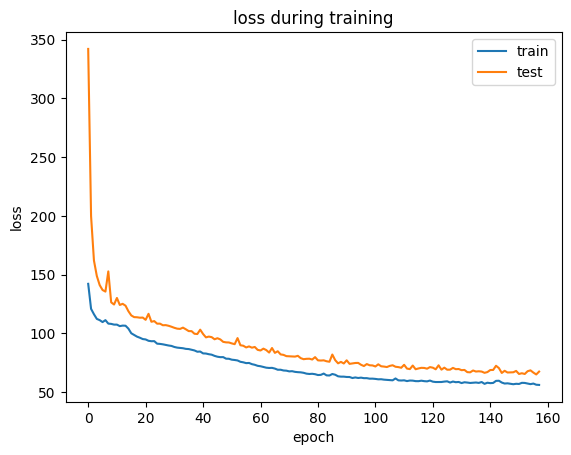

epoch 158: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.378  KLD beta: 1.000
test 	 loss: 64.610


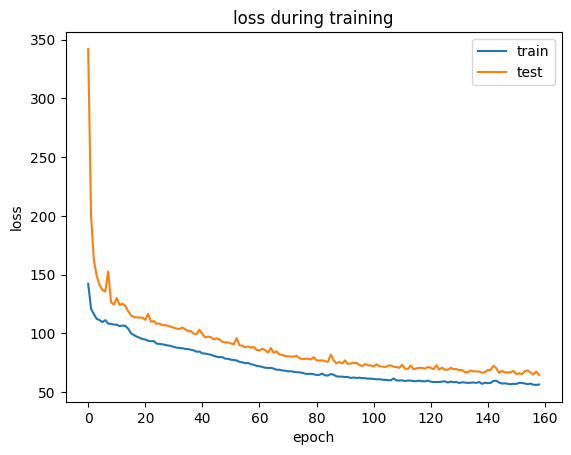

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_158.pt


epoch 159: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 56.743  KLD beta: 1.000
test 	 loss: 66.242


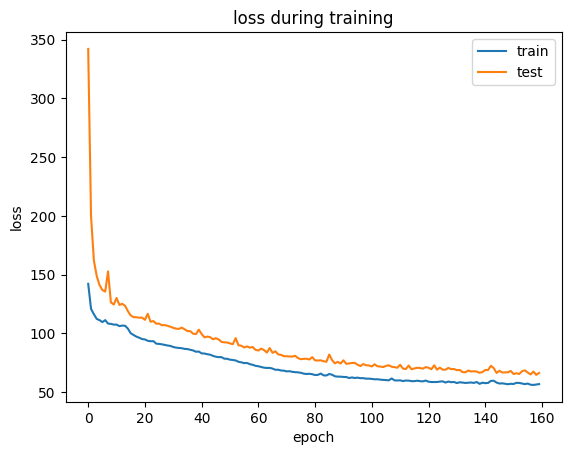

epoch 160: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.427  KLD beta: 1.000
test 	 loss: 66.116


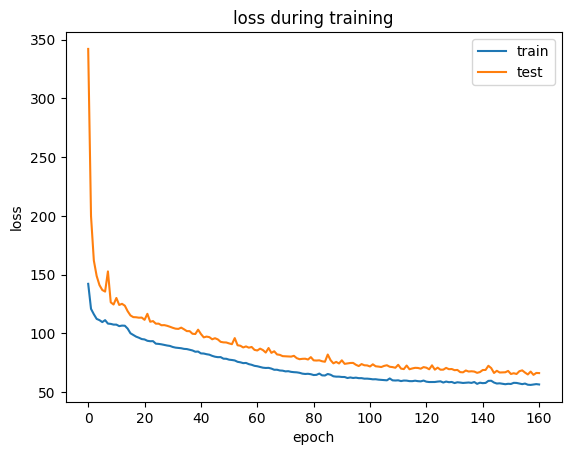

epoch 161: 100%|██████████| 160/160 [00:48<00:00,  3.31it/s]


train 	 loss: 56.265  KLD beta: 1.000
test 	 loss: 64.368


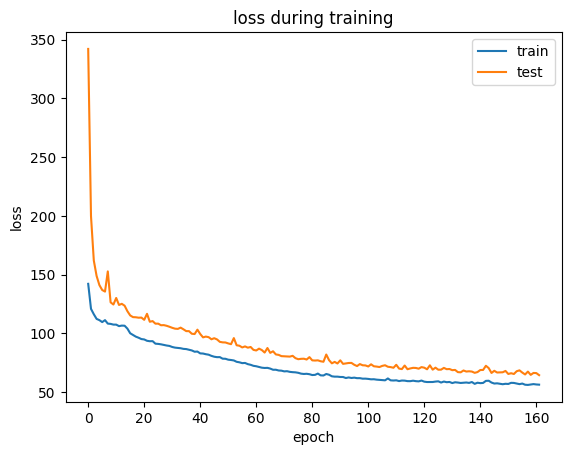

model save at:  /content/drive/MyDrive/A_MODEL/chemVAE/ckpt_161.pt


epoch 162: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.417  KLD beta: 1.000
test 	 loss: 65.833


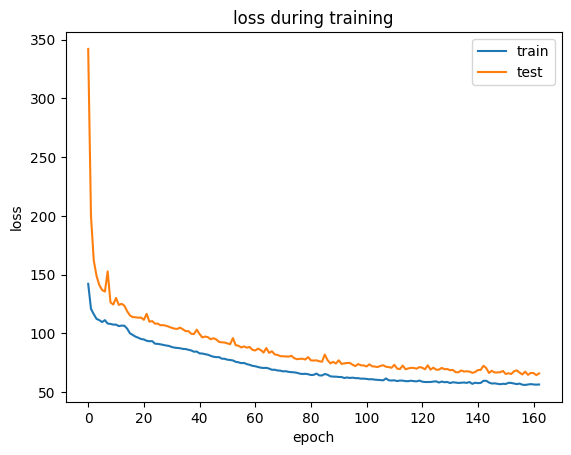

epoch 163: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 67.122  KLD beta: 1.000
test 	 loss: 74.043


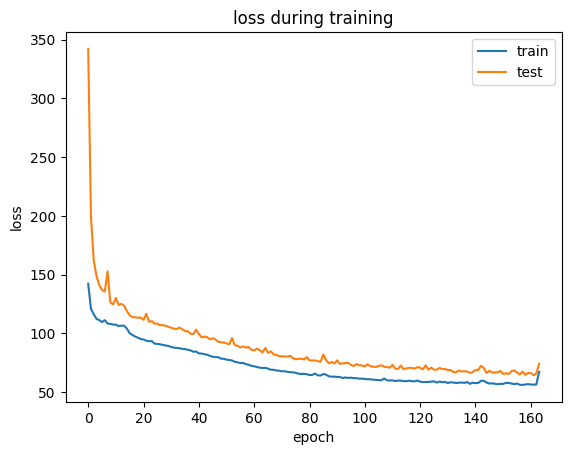

epoch 164: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 60.944  KLD beta: 1.000
test 	 loss: 67.120


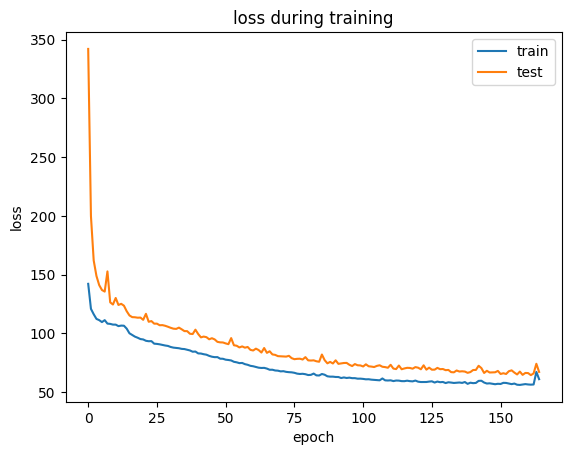

epoch 165: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.999  KLD beta: 1.000
test 	 loss: 65.939


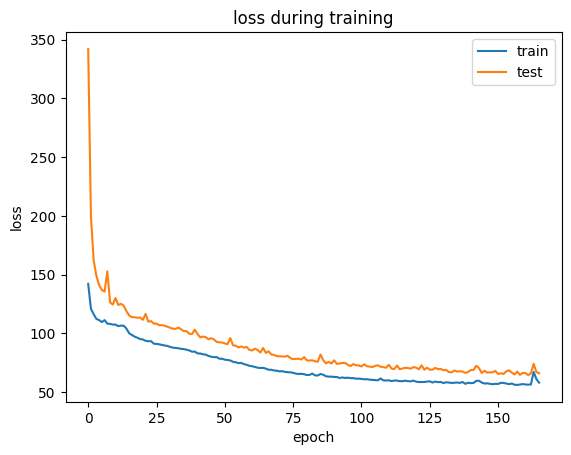

epoch 166: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.726  KLD beta: 1.000
test 	 loss: 64.763


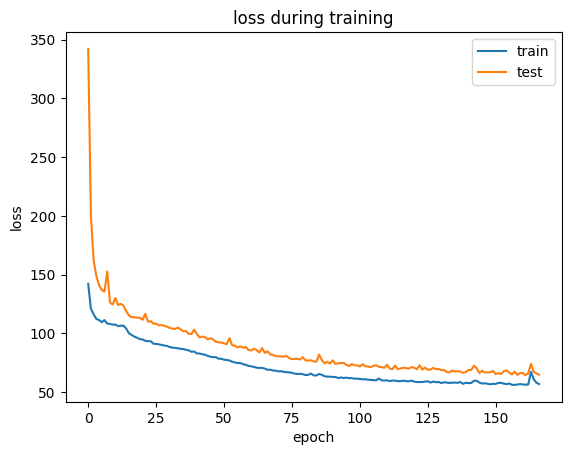

epoch 167: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s]


train 	 loss: 56.581  KLD beta: 1.000
test 	 loss: 66.230


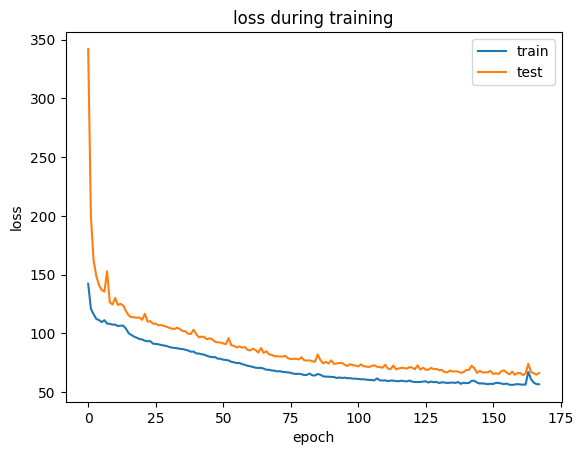

epoch 168: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 61.825  KLD beta: 1.000
test 	 loss: 71.489


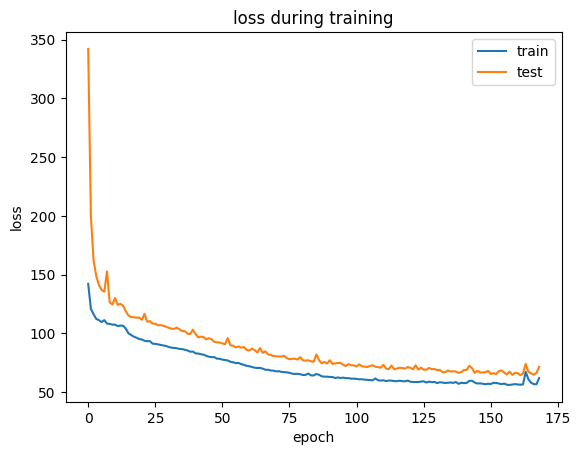

epoch 169: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 57.506  KLD beta: 1.000
test 	 loss: 67.143


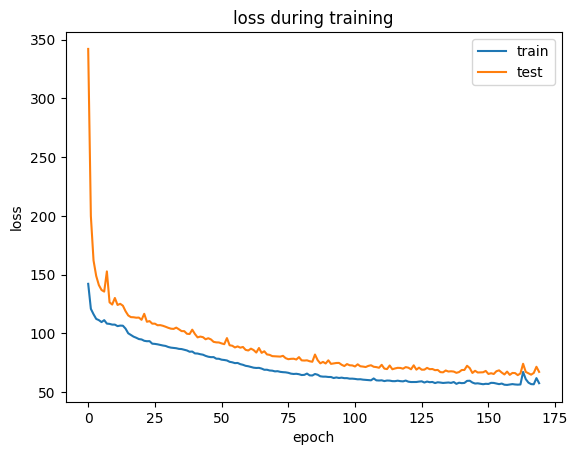

epoch 170: 100%|██████████| 160/160 [00:48<00:00,  3.31it/s]


train 	 loss: 56.326  KLD beta: 1.000
test 	 loss: 67.835


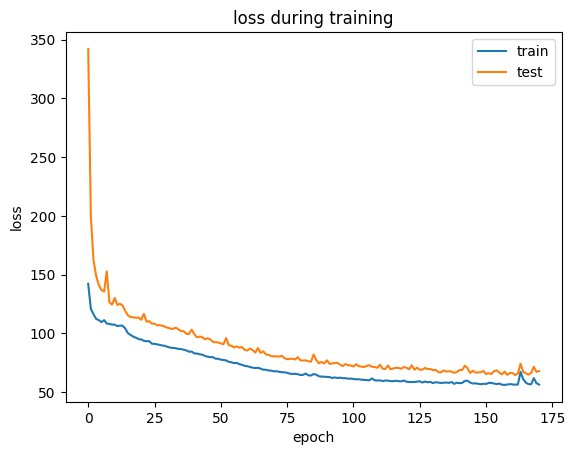

epoch 171: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.769  KLD beta: 1.000
test 	 loss: 65.182


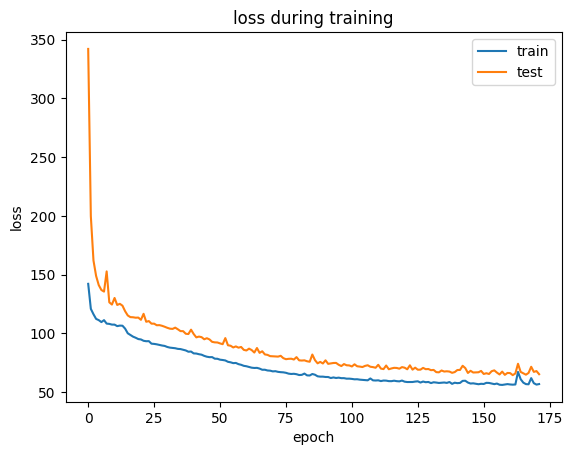

epoch 172: 100%|██████████| 160/160 [00:48<00:00,  3.30it/s]


train 	 loss: 56.391  KLD beta: 1.000
test 	 loss: 65.089


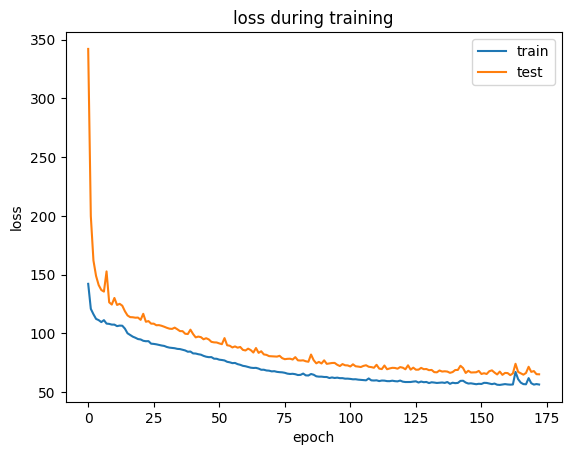

early stop


In [44]:
import os
train_dict, test_dict = {}, {}
model_path = '/content/drive/MyDrive/A_MODEL/chemVAE/'
model_saved_names = []
for epoch in range(epochs):
    train_dict[epoch] = train(epoch)
    if epoch % 1 == 0:
        test_dict[epoch] = test(epoch)

        if epoch != 0:
            plot_loss(train_dict, test_dict)
            argmin_epoch, min_loss = get_min(test_dict)
            save_pkl(train_dict, filename=model_path+'train_loss.pickle')
            save_pkl(test_dict, filename=model_path+'test_loss.pickle')

            if test_dict[epoch] <= min_loss and epoch > 10:
                model_name = model_path+f'ckpt_{str(epoch)}.pt'
                torch.save(model.state_dict(), model_name)
                print('model save at: ',  model_name)
                model_saved_names.append(model_name)
                while len(model_saved_names) > 10:  # only reserve 10 models
                    try:
                        remove_model_name = model_saved_names.pop(0)
                        print('remove ', remove_model_name)
                        os.remove(remove_model_name)
                    except:
                        print(f'error when delete {model_saved_names[0]}')
            else:
                if epoch - argmin_epoch > 10:
                    print('early stop, loss no decrease')
                    break
                if test_dict[epoch] / min_loss > 1.3:
                    print(f'early stop, loss increase')




                    break


In [ ]:
1 <= 2

True

In [ ]:
test_losses = list(test_dict.values())
test_epoches = list(test_dic)

dict_values([226.543886328125, 118.57206484375, 112.3496333984375, 109.2369900390625, 106.9527314453125])

In [ ]:
import copy
d = copy.deepcopy(test_dict)



get_min(d)

(12, 106.9527314453125)

In [ ]:
data

[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 

In [ ]:
data[0].shape

torch.Size([250, 120, 33])

In [ ]:
a=data[0].view(data[0].size(0), -1)

In [ ]:
a.size(0)

250

In [ ]:
new_a = a.view(a.size(0), 1, a.size(-1)).repeat(1, 120, 1)

In [ ]:
new_a.shape

torch.Size([250, 120, 3960])